#Introduction

In this notebook I will train different machine learning models to predict prices of houses.

I will be using cuML library which is part of a RAPIDS environment. cuML is basically sklearn with gpu support. Utilizing gpu will speed up training process significantly.

In [ ]:
!nvidia-smi

Tue Nov 22 12:43:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%%capture
!pip install plotly --upgrade

In [ ]:
%%capture
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

In [ ]:
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

In [ ]:
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [ ]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [ ]:
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

In [ ]:
import cuml
from cuml.pipeline import Pipeline as Pipeline
from cuml.model_selection import GridSearchCV
from cuml.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from cuml.svm import SVR
from cuml.neighbors import KNeighborsRegressor

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import cufflinks as cf
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
import joblib
from sklearn.compose import TransformedTargetRegressor
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline as Pipeline_sk
from sklearn.model_selection import GridSearchCV as GridSearchCV_sk
from sklearn.linear_model import LinearRegression as LinearRegression_sk
import pickle
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/regression project/kc_house_data.csv')

Link to dataset im using on kaggle

https://www.kaggle.com/datasets/harlfoxem/housesalesprediction

#Features descriptions

id - Unique ID for each home sold

date - Date of the home sale

price - Price of each home sold

bedrooms - Number of bedrooms

bathrooms - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

sqft_living - Square footage of the apartments interior living space

sqft_lot - Square footage of the land space

floors - Number of floors

waterfront - A dummy variable for whether the apartment was overlooking the waterfront or not

view - An index from 0 to 4 of how good the view of the property was

condition - An index from 1 to 5 on the condition of the apartment

grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

sqft_above - The square footage of the interior housing space that is above ground level

sqft_basement - The square footage of the interior housing space that is below ground level

yr_built - The year the house was initially built

yr_renovated - The year of the house’s last renovation

zipcode - What zipcode area the house is in

lat - Lattitude

long - Longitude

sqft_living15 - The square footage of interior housing living space for the nearest 15 neighbors

sqft_lot15 - The square footage of the land lots of the nearest 15 neighbors

Looking only at head of this df I noticed something strange about bathrooms column, second row has a value of 2.25. These values should be integers or x.5 if some bathrooms only have a toilet. I have no idea why quaters would appear but I will deal with that issue later.

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


There are couple of features with correlation with price over 0.5. High correlation with price is good because that means there is a relationship between changes in these features and price. 

Some features are strongly correlated with each other but it's not high enough to cause multicollinearity but even if it occurs it doesn't influence predictive power.


#Disclaimer
When I was working in colab I used plotly for visialization but these plots are not displayed in jupyter notebook so I also included screenshots of them.

In [ ]:
fig = px.imshow(np.round(df.corr(), 3), text_auto=True,
                width=1000, height=1000)
fig.show()

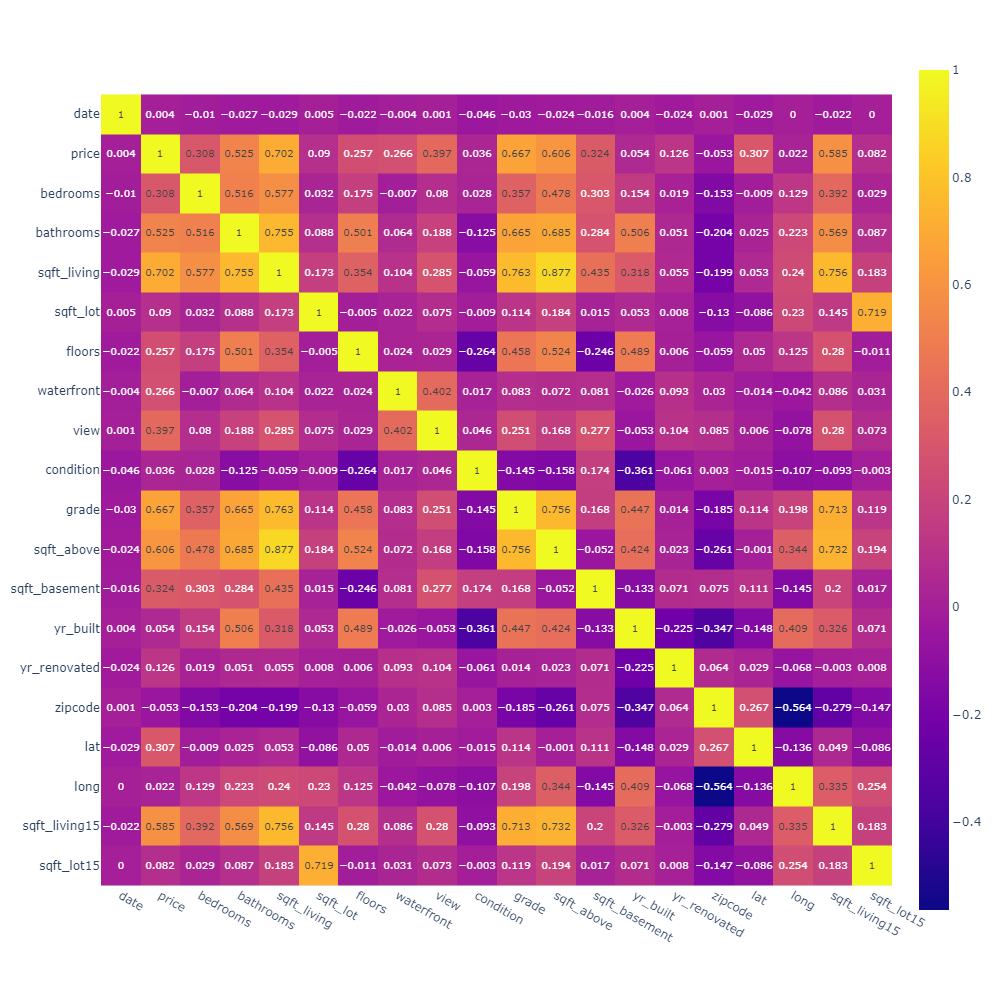

#Missing data

There are no obvious missing values. None of the columns have any empty fields. All columns except the date are numerical dtypes as they should be and that is a good sign because that means there are no strings indicating missing values like '?' or 'nan'. There might be some numeric rows like 'yr_built' containing 0 values indicating that value is missing. In order to find these rows and visualize the data let's plot their distribiutions and box plots.

Before ploting distribiutions I'll drop usless column id and extract only the year from date.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [ ]:
df = df.drop(['id'], axis=1)

In [ ]:
df['date'] = df['date'].map(lambda x: int(x[:4]))

In [ ]:
for colname in df.columns:
    fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{colname} distribiution', f'{colname} boxplot'))
    fig.add_trace(go.Histogram(x=df[colname], nbinsx=15), row=1, col=1)
    fig.add_trace(go.Box(x=df[colname]), row=1, col=2)
    fig.show()

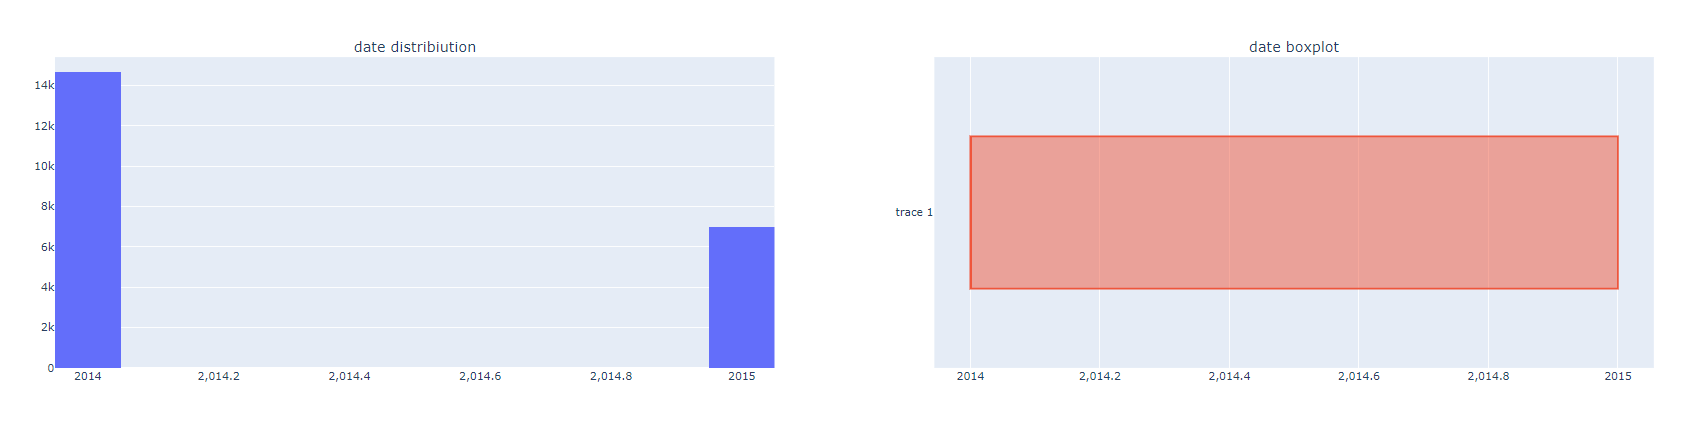

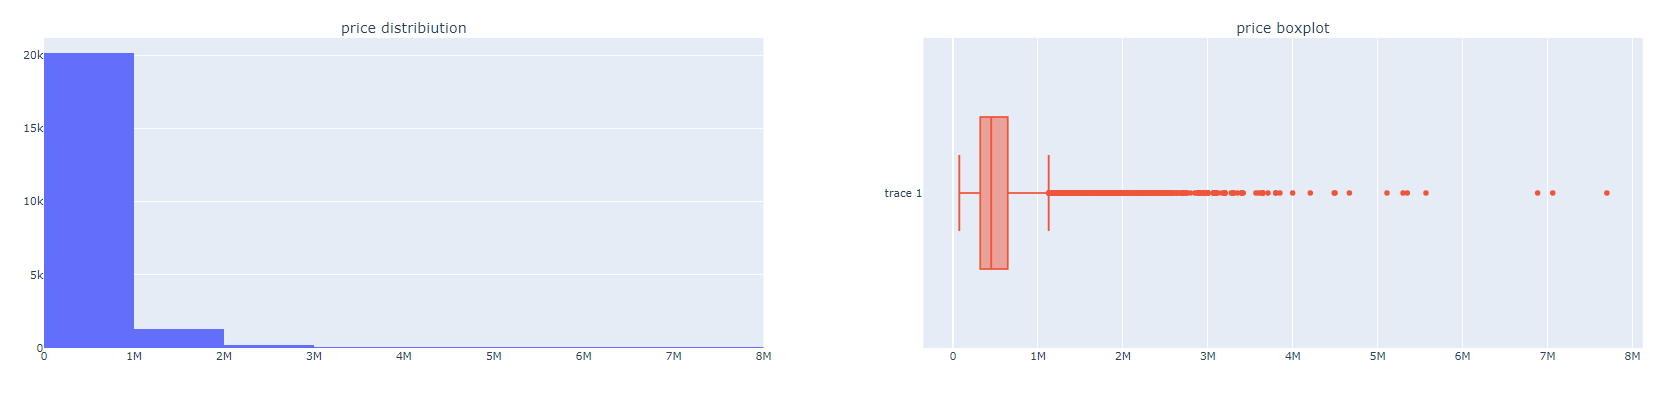

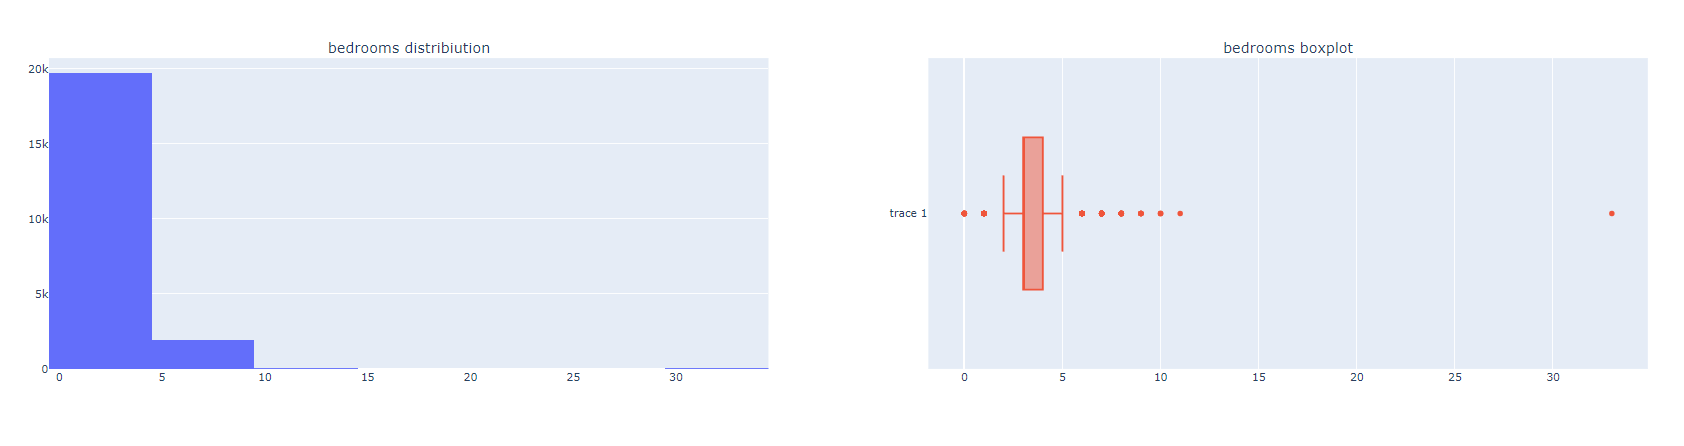

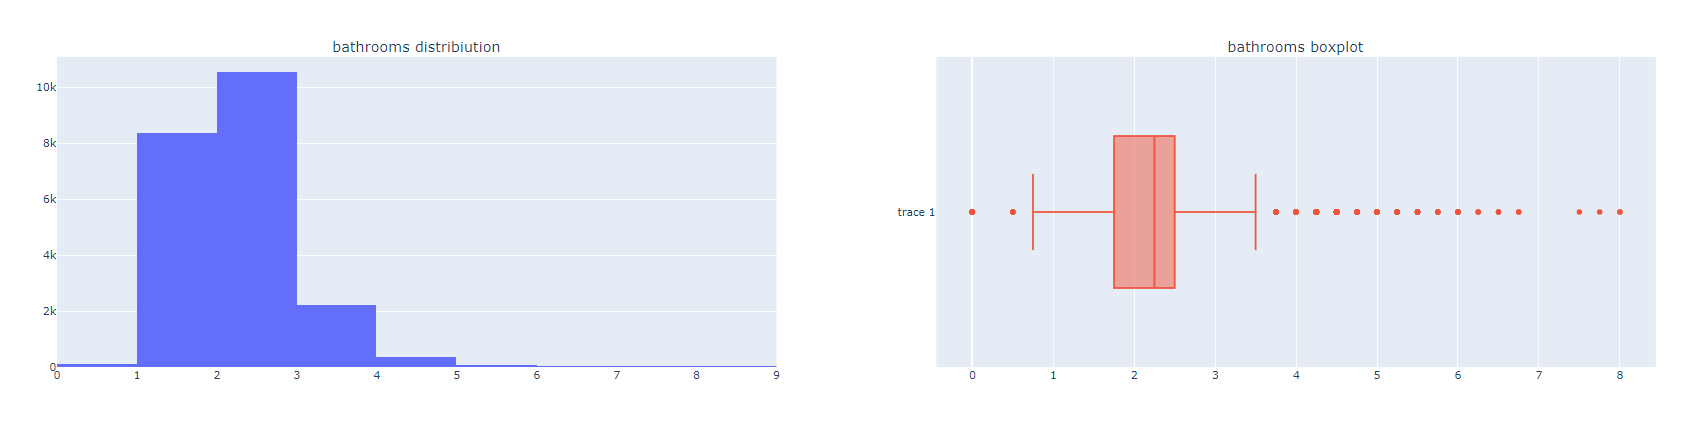

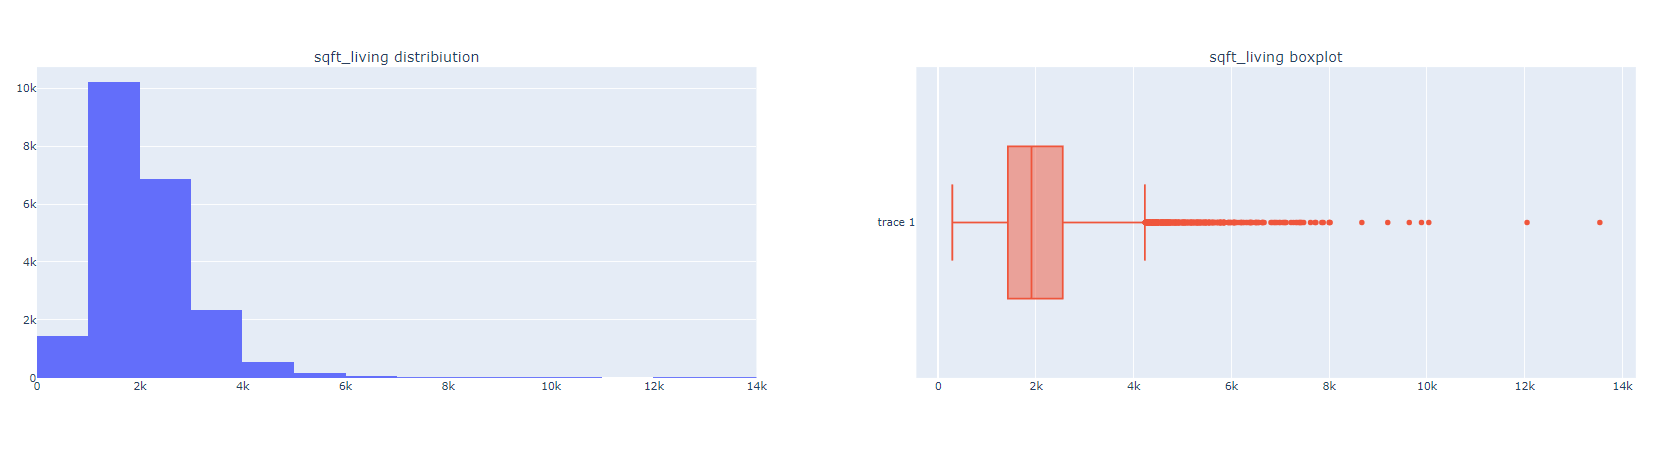


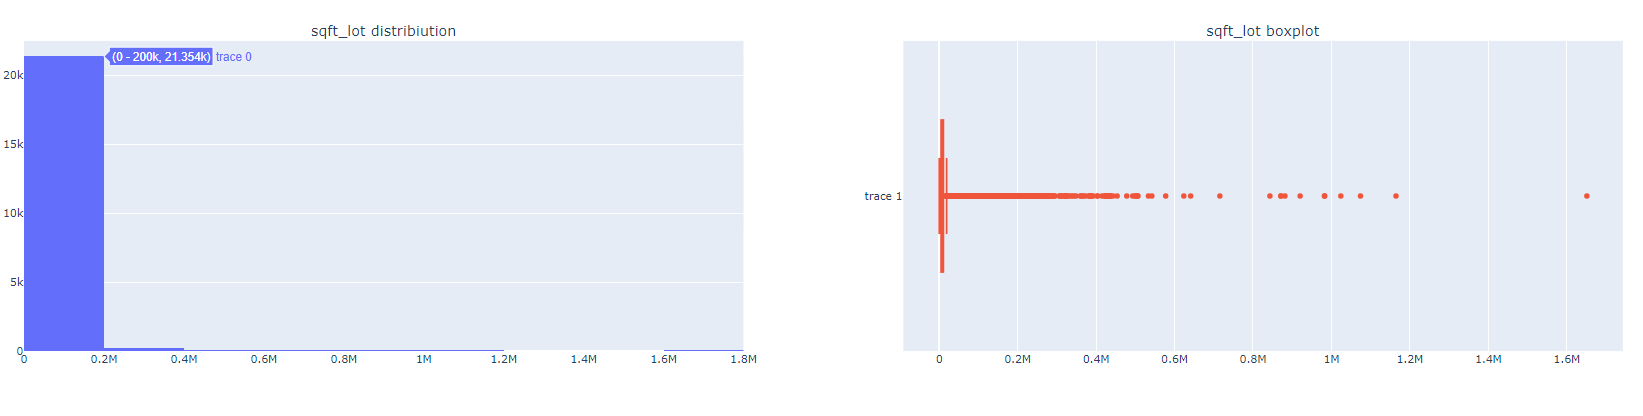

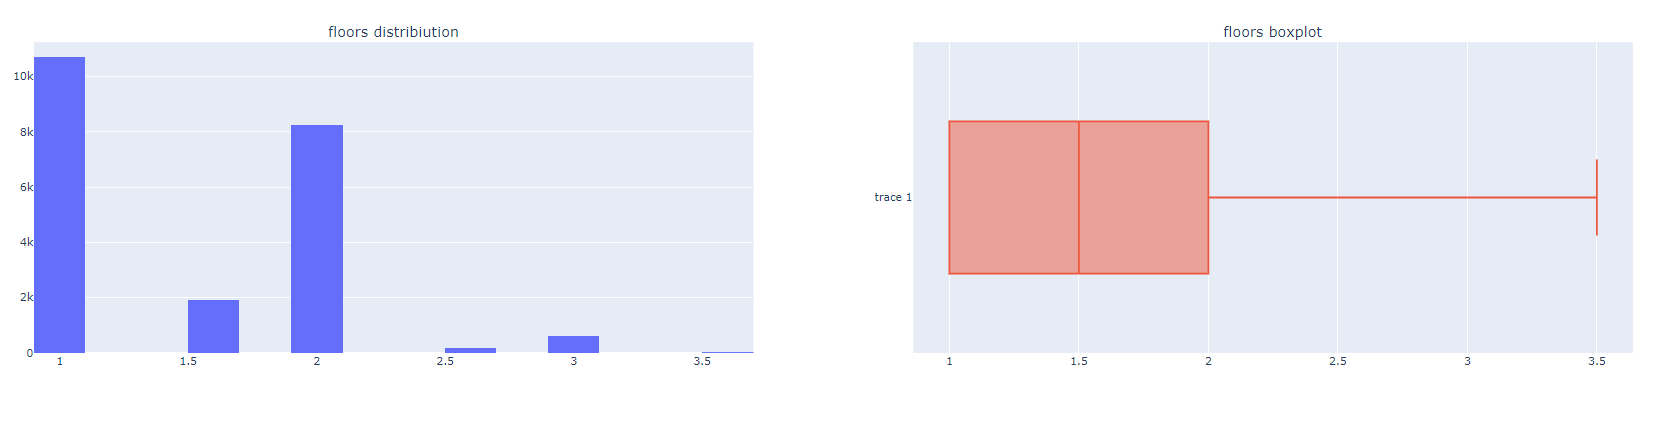

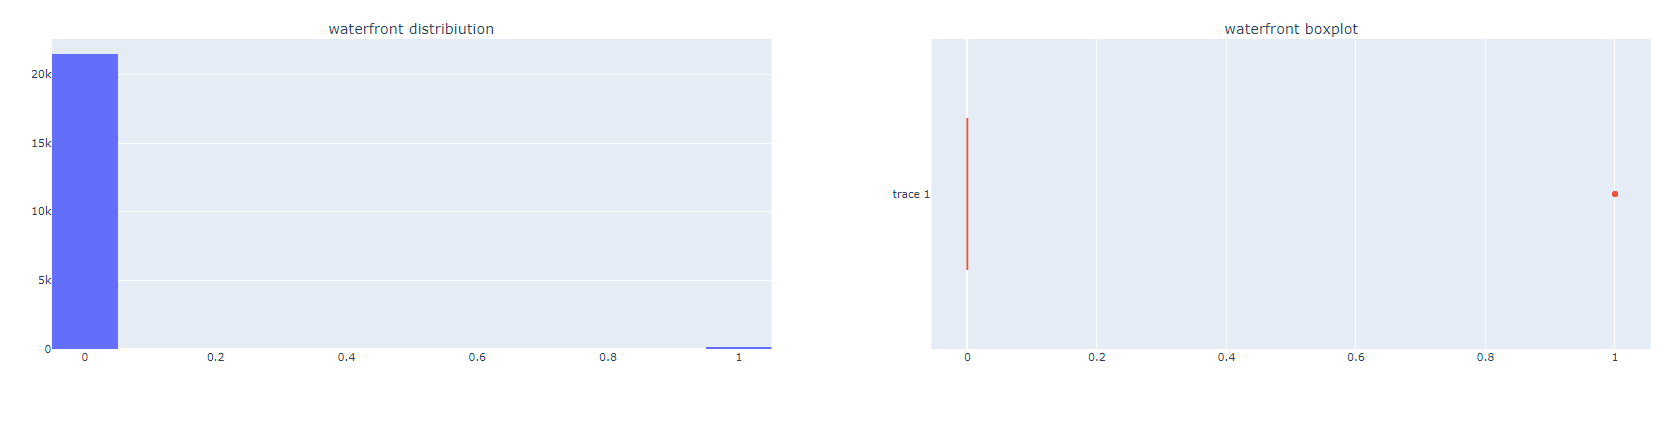

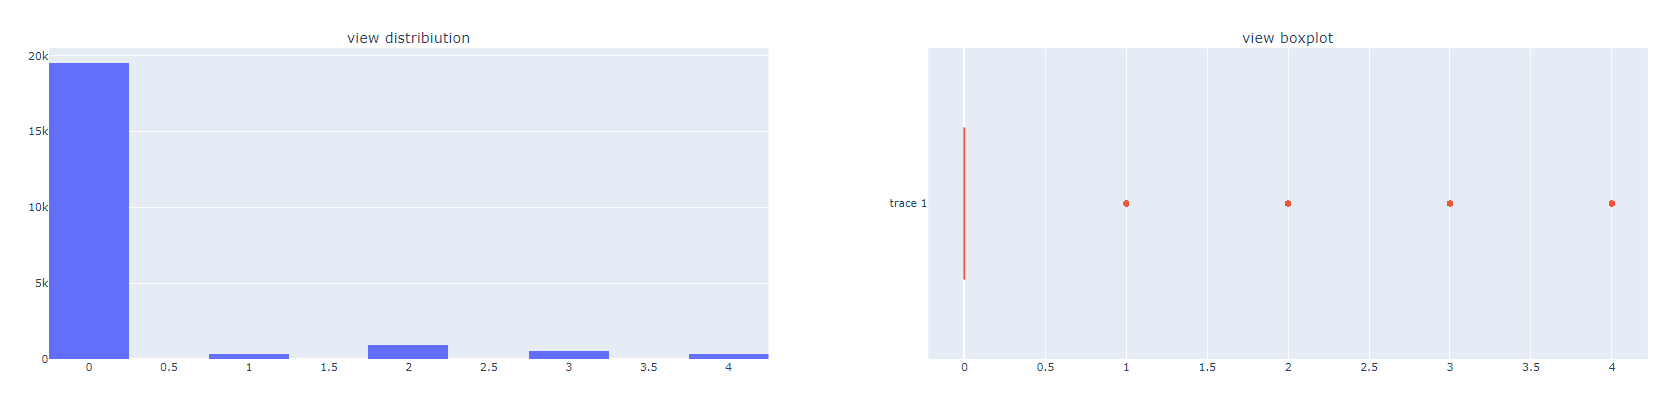

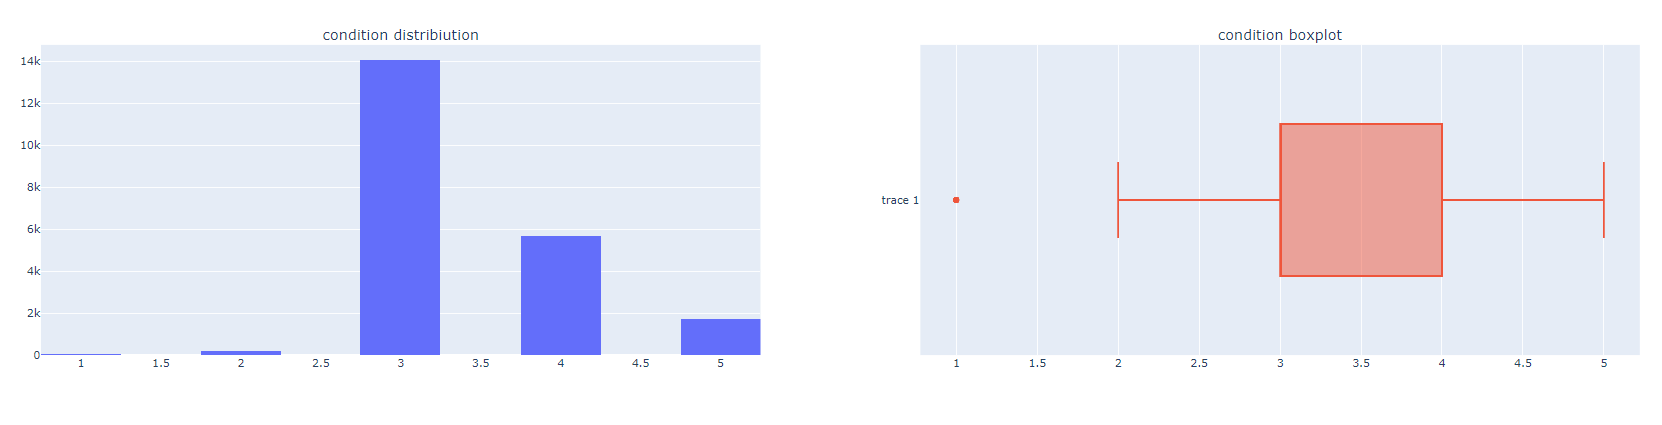

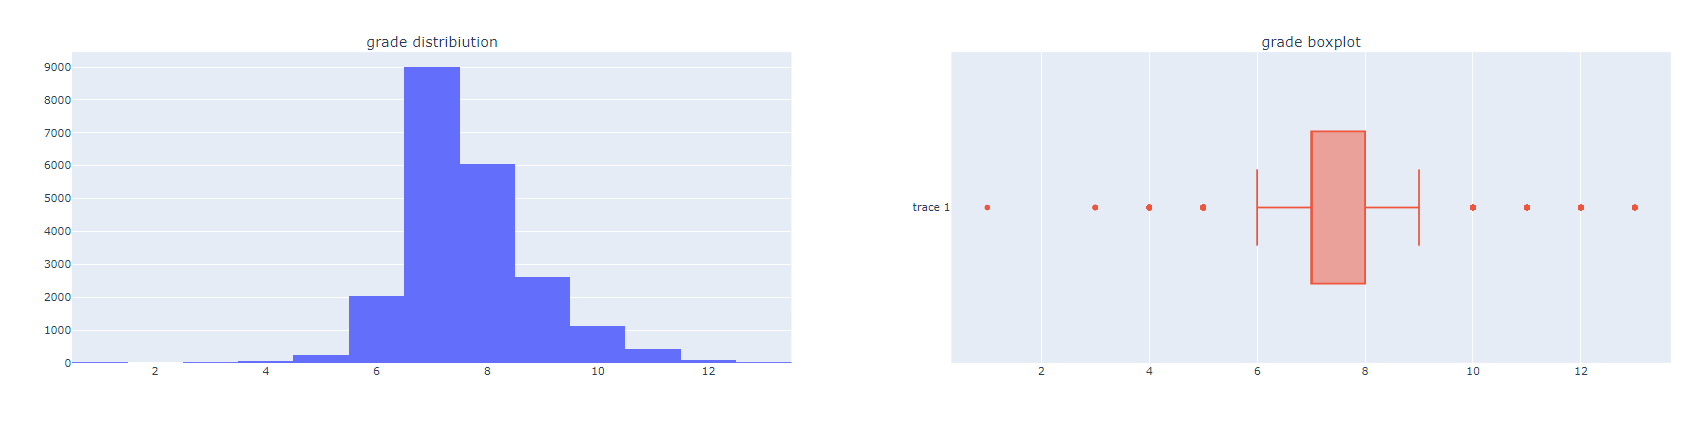

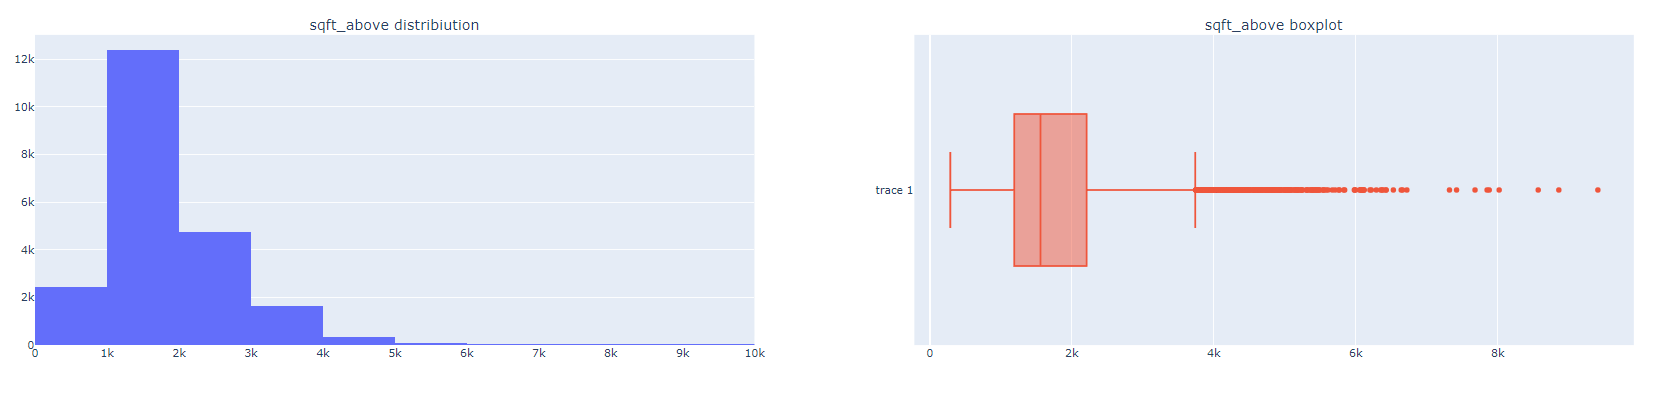

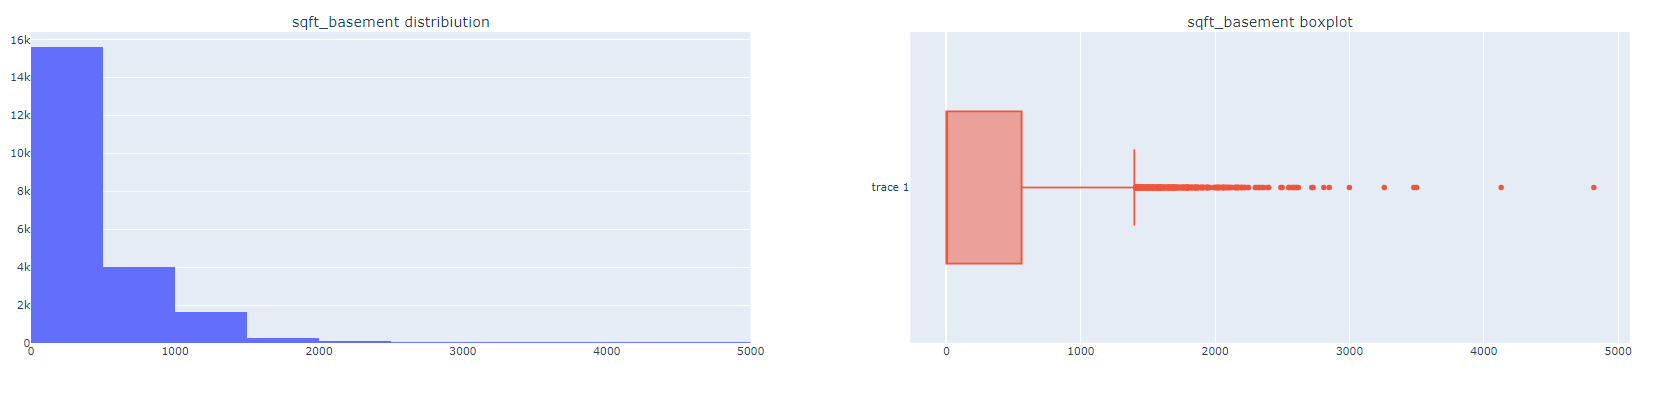

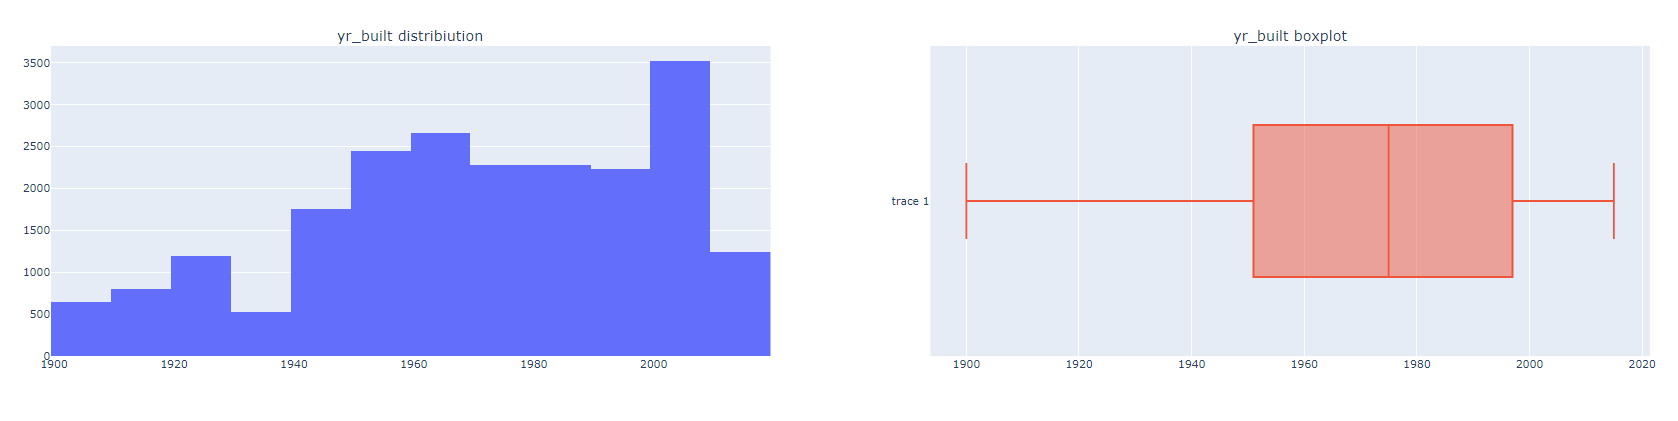

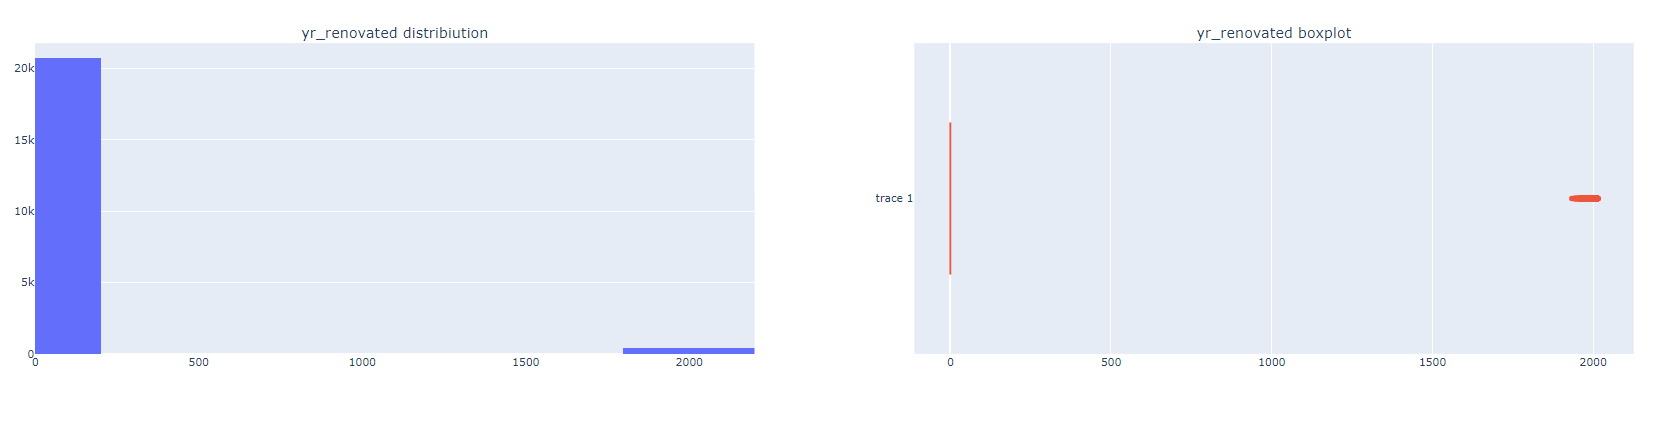

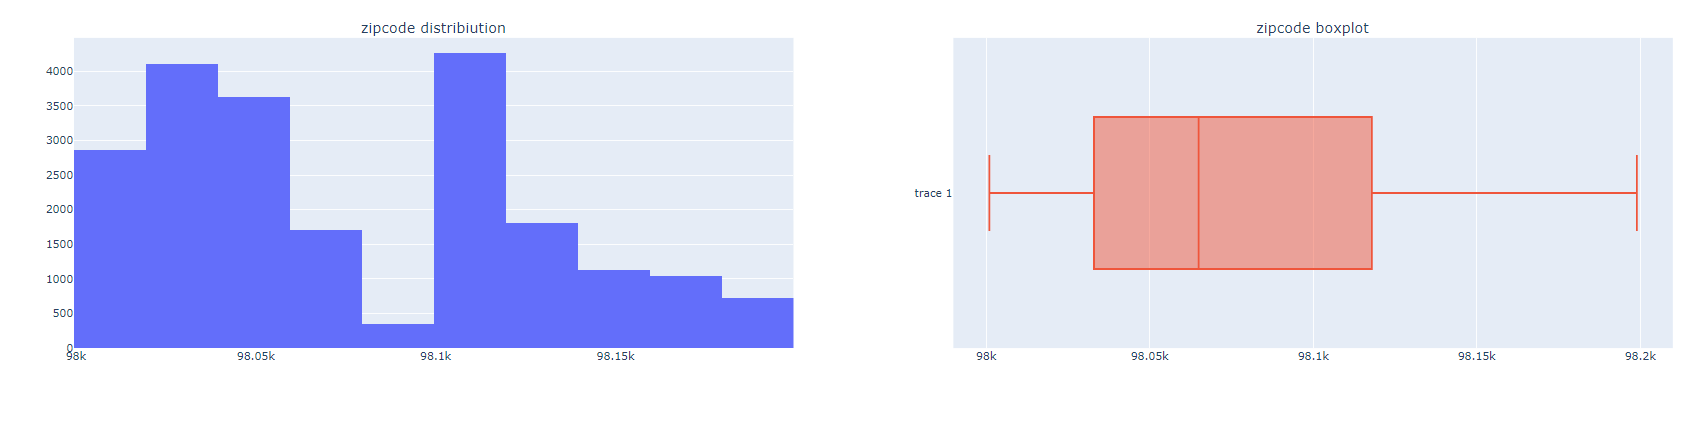

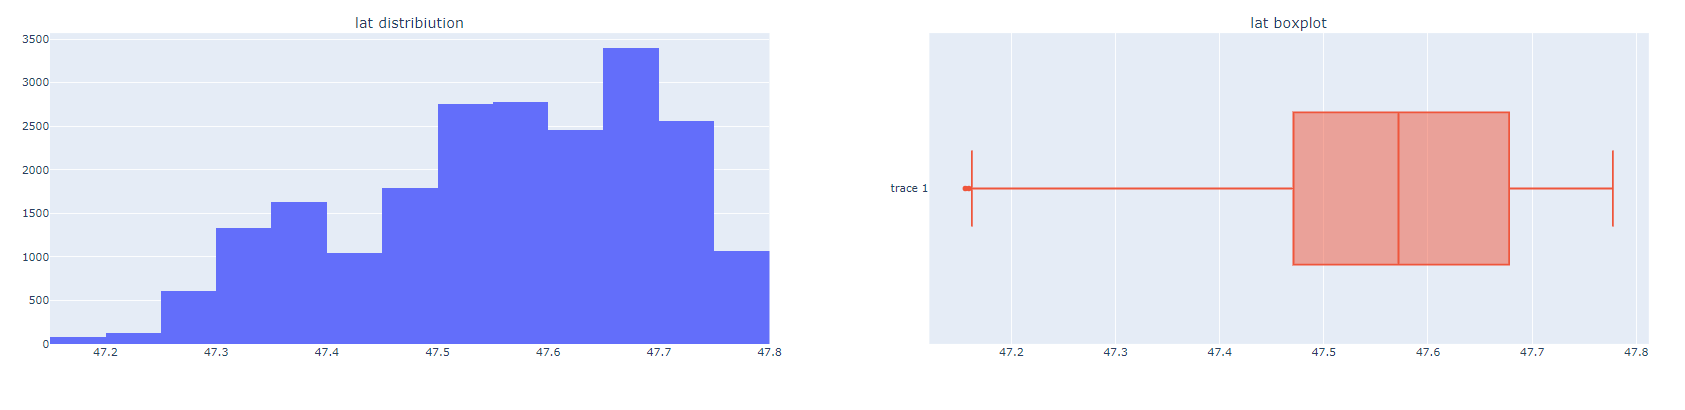

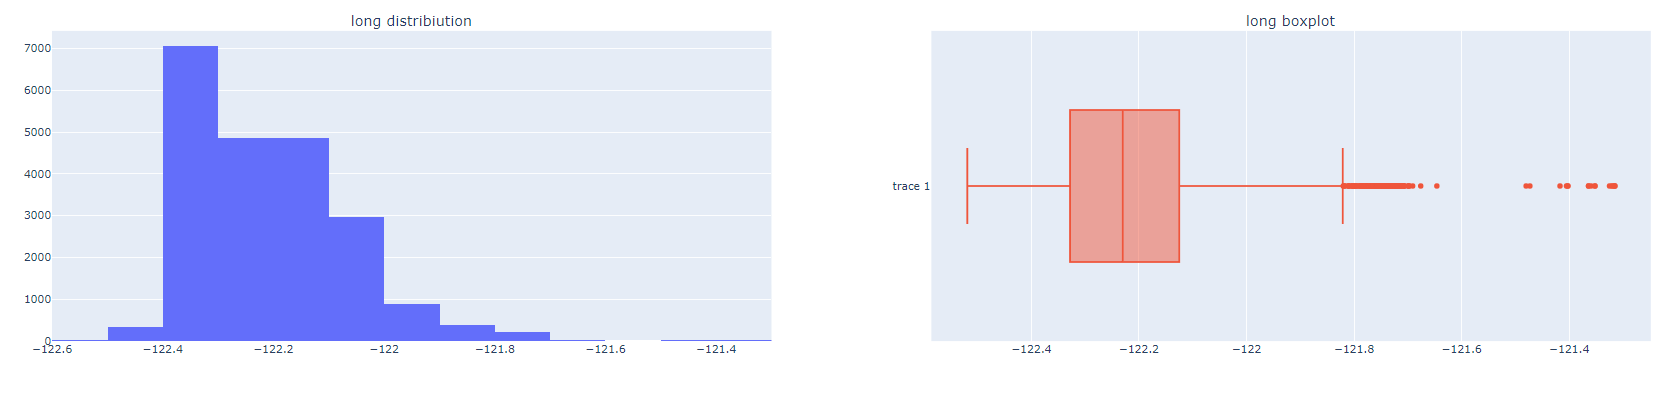

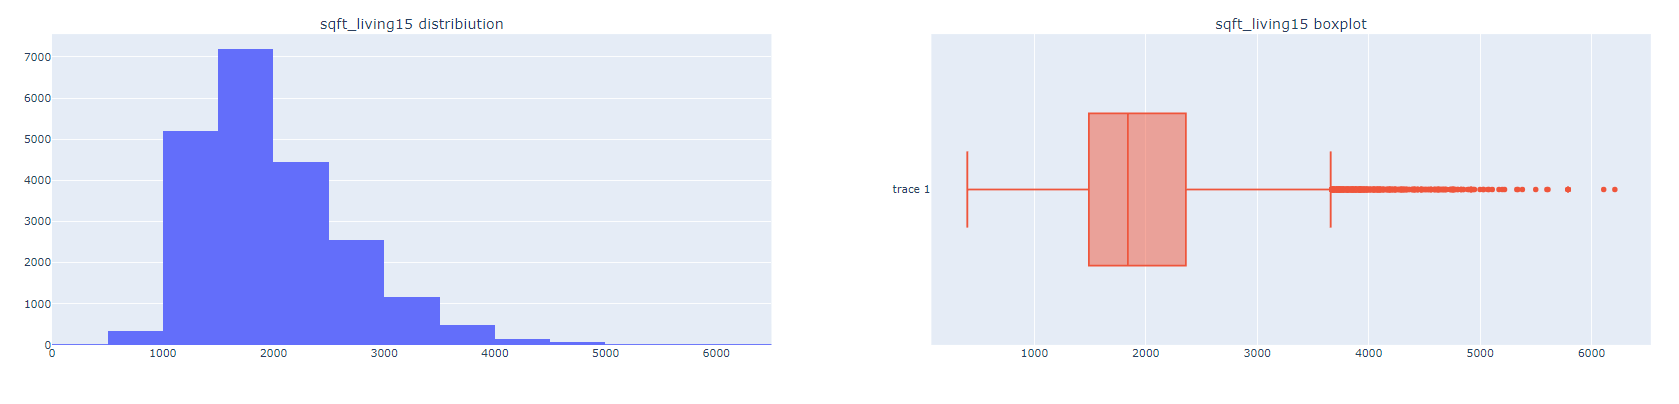

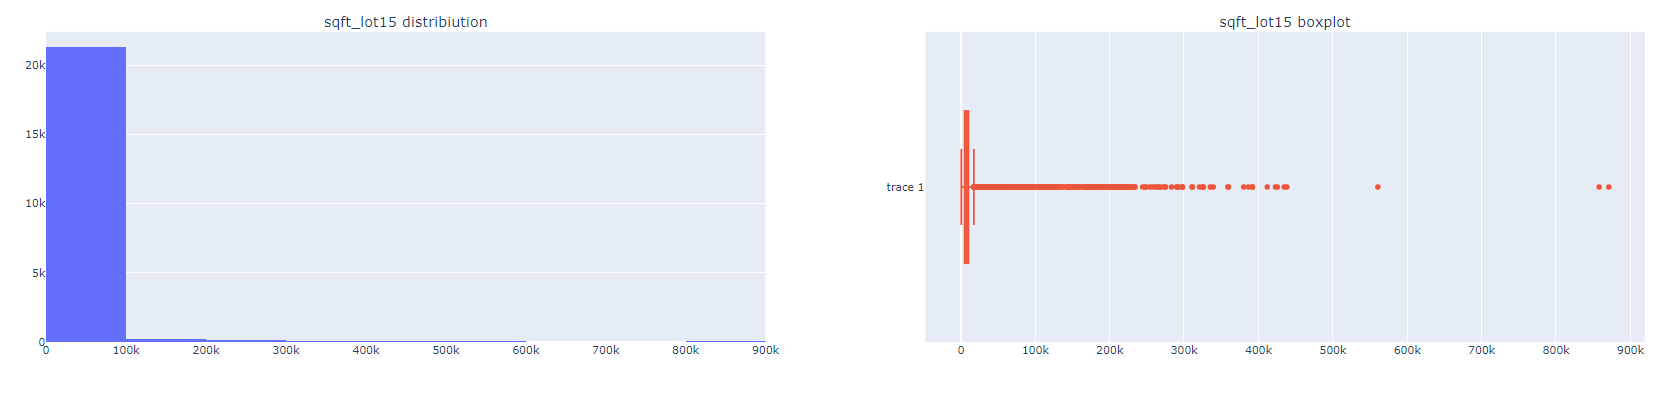

#Removing outliers

Looking through box plots and histograms I didn't find any columns that have 0 values when they shouldn't have them. There are some outliers according to iqr method so let's look into that. First let's count how many are there.

In [ ]:
outliers_iqr = {}
for colname in df.columns:
  upper_fence = df[colname].quantile(0.75) + (df[colname].quantile(0.75) - df[colname].quantile(0.25)) * 1.5
  if upper_fence > df[colname].max():
    upper_fence = df[colname].max()
  else:
    None

  lower_fence = df[colname].quantile(0.25) - (df[colname].quantile(0.75) - df[colname].quantile(0.25)) * 1.5
  if lower_fence < df[colname].min():
    lower_fence = df[colname].min()
  else:
    None

  count = len(df[df[colname] > upper_fence]) + len(df[df[colname] < lower_fence])
  outliers_iqr[colname] = {'count': count, 'lower fence': lower_fence, 'upper fence': upper_fence, 'percentage': count/len(df)*100}

As you can see there are two features with over 10% samples classified as outilers by iqr method, these columns are sqft_lot and sqft_lot15. Over 5% of price samples are classified as outliers.

In [ ]:
iqr_results = pd.DataFrame(outliers_iqr).T
iqr_results = np.round(iqr_results, 2)
pd.concat([iqr_results, np.round(df.describe(percentiles=[.01, .05, .25, .5, .75, .8, .90, .95, .99]), 2).T], axis=1)

,count,lower fence,upper fence,percentage,count,mean,std,min,1%,5%,25%,50%,75%,80%,90%,95%,99%,max
date,0.0,2014.00,2015.00,0.00,21613.0,2014.32,0.47,2014.00,2014.00,2014.00,2014.00,2014.00,2015.00,2015.00,2015.00,2015.00,2015.00,2015.00
price,1146.0,75000.00,1129575.00,5.30,21613.0,540088.14,367127.20,75000.00,153500.36,210000.00,321950.00,450000.00,645000.00,700108.00,887000.00,1156480.00,1964400.00,7700000.00
bedrooms,546.0,1.50,5.50,2.53,21613.0,3.37,0.93,0.00,2.00,2.00,3.00,3.00,4.00,4.00,4.00,5.00,6.00,33.00
bathrooms,571.0,0.62,3.62,2.64,21613.0,2.11,0.77,0.00,1.00,1.00,1.75,2.25,2.50,2.50,3.00,3.50,4.25,8.00
sqft_living,572.0,290.00,4234.50,2.65,21613.0,2079.90,918.44,290.00,720.00,940.00,1427.00,1910.00,2550.00,2730.00,3250.00,3760.00,4978.80,13540.00
sqft_lot,2425.0,520.00,19160.00,11.22,21613.0,15106.97,41420.51,520.00,1013.12,1800.00,5040.00,7618.00,10688.00,12186.60,21397.60,43339.20,213008.00,1651359.00
floors,0.0,1.00,3.50,0.00,21613.0,1.49,0.54,1.00,1.00,1.00,1.00,1.50,2.00,2.00,2.00,2.00,3.00,3.50
waterfront,163.0,0.00,0.00,0.75,21613.0,0.01,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
view,2124.0,0.00,0.00,9.83,21613.0,0.23,0.77,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,4.00,4.00
condition,30.0,1.50,5.00,0.14,21613.0,3.41,0.65,1.00,3.00,3.00,3.00,3.00,4.00,4.00,4.00,5.00,5.00,5.00


Sometimes value of a property comes from it's uniqueness or other factors that are not reflected in the data. I want to find these houses and remove them from the data as I consider them to be outliers. 

In [ ]:
len(df[df['price'] > 2000000])

198

In [ ]:
len(df[df['price'] > 1156480])

1081

In [ ]:
len(df[df['price'] > 887000])

2161

In [ ]:
len(df[(df['sqft_living'] > 3250)])

2161

In [ ]:
np.round(df.describe(percentiles=[.01, .05, .25, .5, .75, .8, .85, .90, .95, .99])[['price', 'sqft_living', 'grade', 'bathrooms', 'bedrooms']], 2).T

,count,mean,std,min,1%,5%,25%,50%,75%,80%,85%,90%,95%,99%,max
price,21613.0,540088.14,367127.20,75000.0,153500.36,210000.0,321950.00,450000.00,645000.0,700108.0,779494.00,887000.0,1156480.0,1964400.00,7700000.0
sqft_living,21613.0,2079.90,918.44,290.0,720.00,940.0,1427.00,1910.00,2550.0,2730.0,2970.00,3250.0,3760.0,4978.80,13540.0
grade,21613.0,7.66,1.18,1.0,5.00,6.0,7.00,7.00,8.0,8.0,9.00,9.0,10.0,11.00,13.0
bathrooms,21613.0,2.11,0.77,0.0,1.00,1.0,1.75,2.25,2.5,2.5,2.75,3.0,3.5,4.25,8.0
bedrooms,21613.0,3.37,0.93,0.0,2.00,2.0,3.00,3.00,4.0,4.0,4.00,4.0,5.0,6.00,33.0


It can be seen on the plots below that some houses have prices greater than 95th percentile but their sqft of living space, grade and other most correlated with price columns don't reflect that. Big factor in propety's price is also it's location, there are columns with latitude and longitude but I won't use them for outliers detection because I don't know how to utilize raw coordinates in a way that would make sense. If the discrepancy between price and most correlated with price features will be big I'm going to delete these rows. What I mean by big discrepancy is for example when price is in 80th percentile but other columns are in 40th or 50th percentile. For a sample to be classified as outlier the discrepancy needs to be big enough on at least 2 features.

In [ ]:
fig = px.scatter(df, x="sqft_living", y="price", color='grade', trendline='ols')
fig.show()

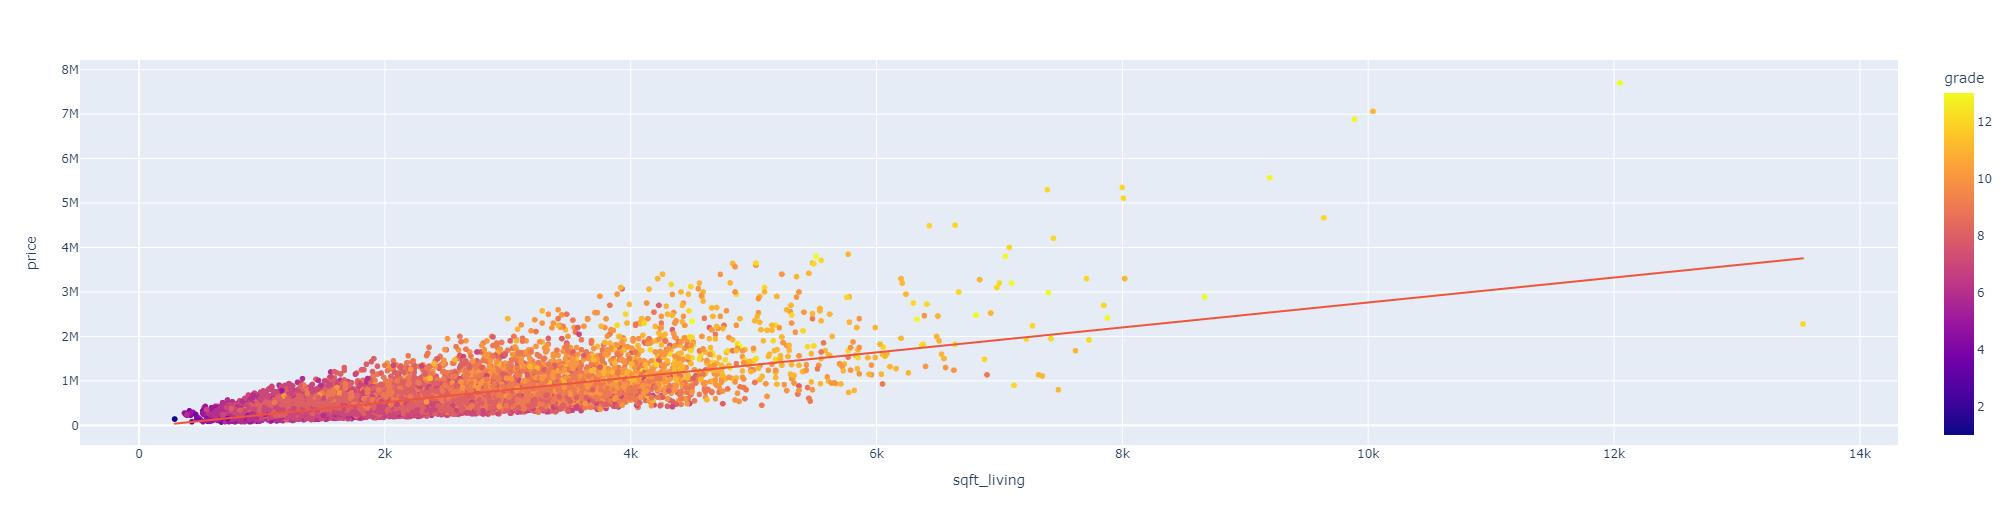

In [ ]:
fig = px.scatter(df, x="sqft_lot", y="price", color='grade', trendline='ols')
fig.show()

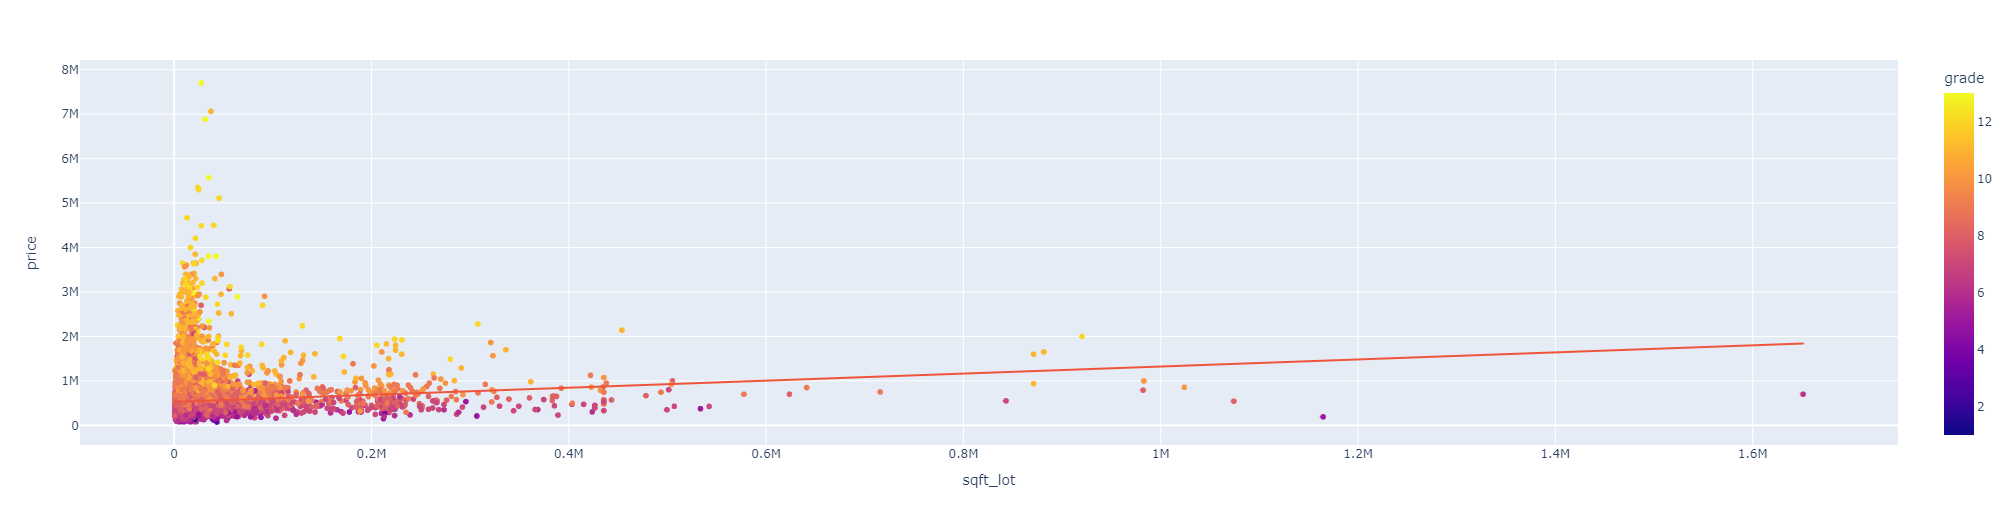

In [ ]:
fig = px.scatter(df, x="bedrooms", y="price", color='bathrooms')
fig.show()

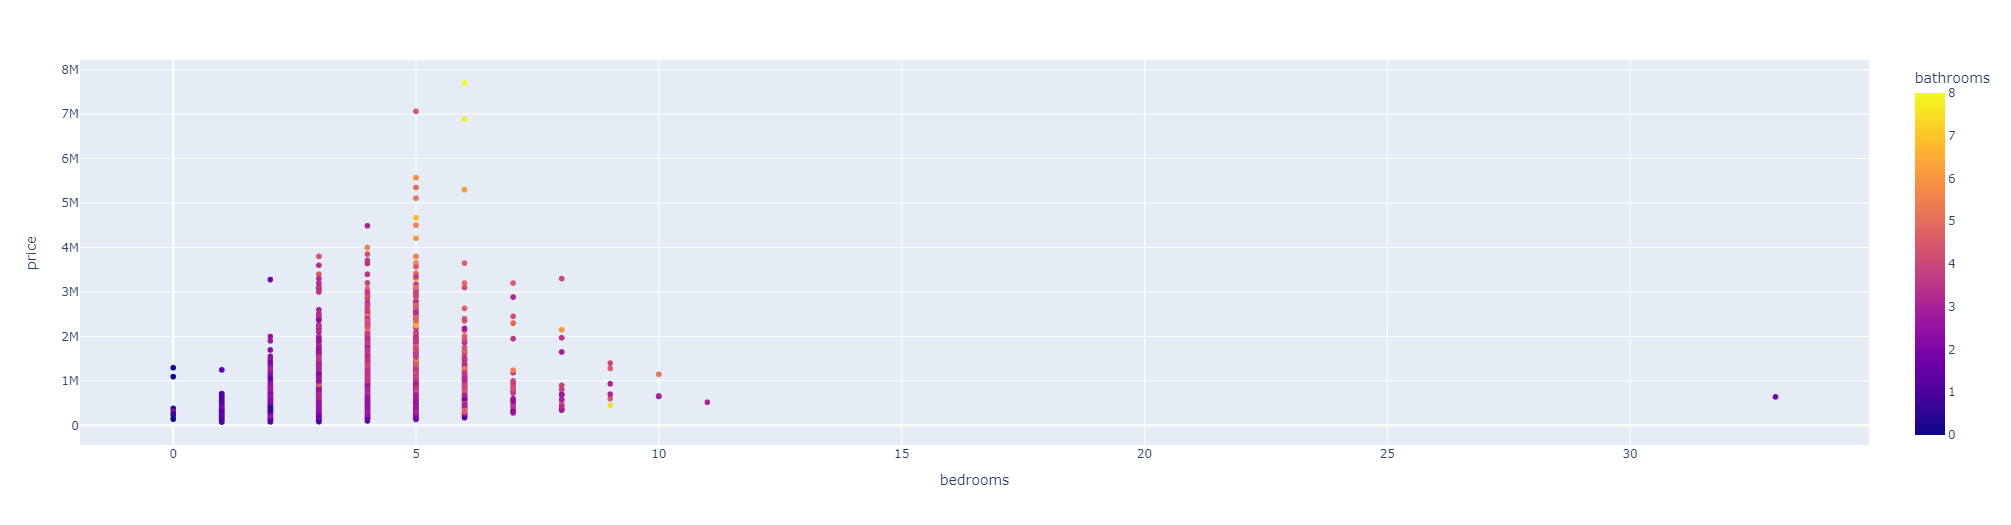

In [ ]:
fig = px.scatter(df, x="grade", y="price")
fig.show()

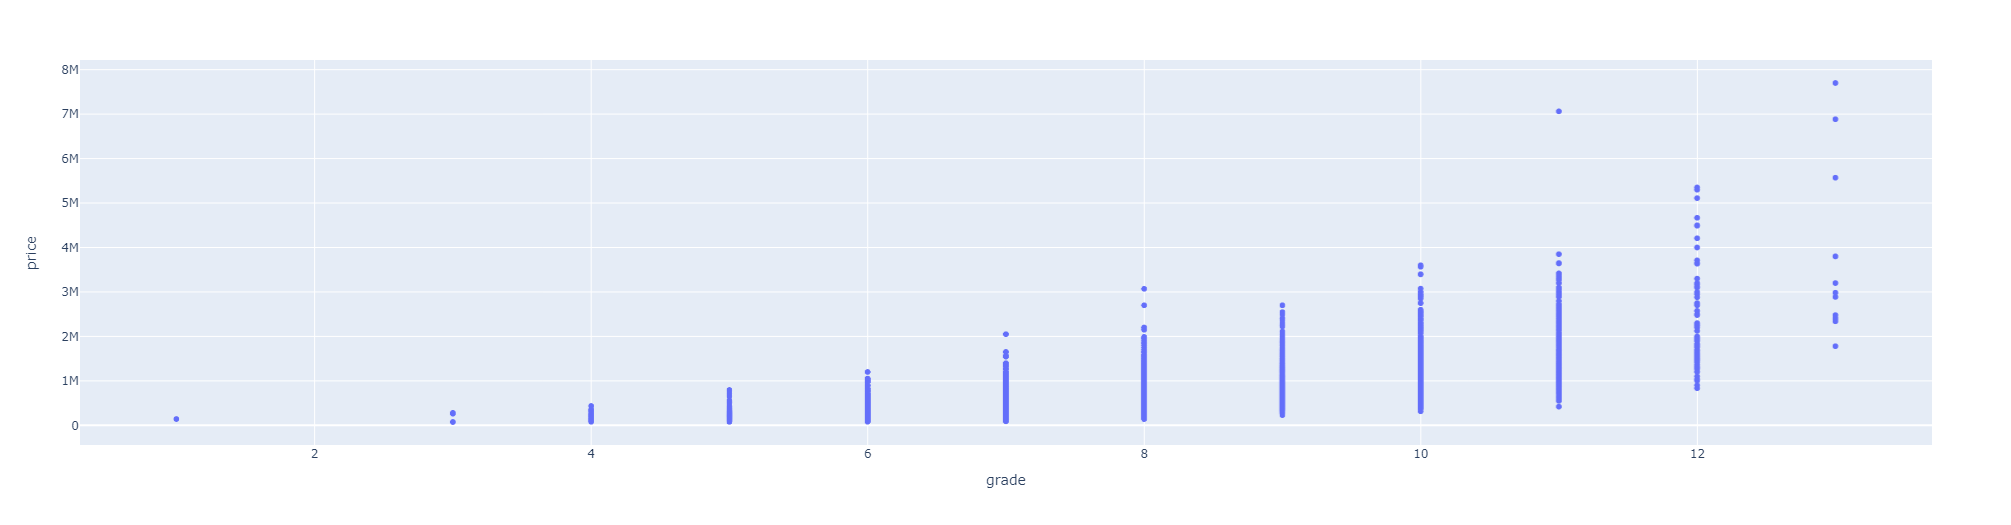

In [ ]:
np.round(df.describe(percentiles=[.1, .2, .25, .3, .4, .45, .5, .7, .75, .8, .85, .90, .95, .99])[['price', 'sqft_living', 'grade', 'bathrooms', 'bedrooms']], 2).T

,count,mean,std,min,10%,20%,25%,30%,40%,45%,50%,70%,75%,80%,85%,90%,95%,99%,max
price,21613.0,540088.14,367127.20,75000.0,245000.0,298470.0,321950.00,345000.00,399500.0,425000.0,450000.00,595000.0,645000.0,700108.0,779494.00,887000.0,1156480.0,1964400.00,7700000.0
sqft_living,21613.0,2079.90,918.44,290.0,1090.0,1320.0,1427.00,1520.00,1710.0,1810.0,1910.00,2400.0,2550.0,2730.0,2970.00,3250.0,3760.0,4978.80,13540.0
grade,21613.0,7.66,1.18,1.0,6.0,7.0,7.00,7.00,7.0,7.0,7.00,8.0,8.0,8.0,9.00,9.0,10.0,11.00,13.0
bathrooms,21613.0,2.11,0.77,0.0,1.0,1.5,1.75,1.75,2.0,2.0,2.25,2.5,2.5,2.5,2.75,3.0,3.5,4.25,8.0
bedrooms,21613.0,3.37,0.93,0.0,2.0,3.0,3.00,3.00,3.0,3.0,3.00,4.0,4.0,4.0,4.00,4.0,5.0,6.00,33.0


There are 226 houses which price exceeds their 95th percentile but their sqft living doesn't exceed it's 90th percentile and sqft lot doesn't exceed it's 80th percentile. 

In [ ]:
len(df[((df['sqft_living'] <= 3250) & (df['price'] > 1156480) & (df['sqft_lot'] < 12186))])

226

There are 127 houses which price exceeds their 95th percentile but their sqft living doesn't exceed it's 80th and sqft lot doesn't exceed it's 90th percentile. 

In [ ]:
len(df[(df['sqft_living'] <= 2730) & (df['price'] > 1156480) & (df['sqft_lot'] < 21397)])

127

There are 264 houses with price higher than it's 90th percentile and their's sqft living and sqft lot lower than their 70th percentiles.

In [ ]:
len(df[((df['sqft_living'] <= 2550) & (df['price'] > 887000) & (df['sqft_lot'] < 10688))])

264

There are 469 unique rows in these 3 sets combined.

I'm going to delete them and continue looking for other outliers.

In [ ]:
len(df[((df['sqft_living'] <= 3250) & (df['price'] > 1156480) & (df['sqft_lot'] < 12186)) | (df['sqft_living'] <= 2730) & (df['price'] > 1156480) & (df['sqft_lot'] < 21397) | ((df['sqft_living'] <= 2550) & (df['price'] > 887000) & (df['sqft_lot'] < 10688))])

469

In [ ]:
idx_outlier = df[((df['sqft_living'] <= 3250) & (df['price'] > 1156480) & (df['sqft_lot'] < 12186)) | (df['sqft_living'] <= 2730) & (df['price'] > 1156480) & (df['sqft_lot'] < 21397) | ((df['sqft_living'] <= 2550) & (df['price'] > 887000) & (df['sqft_lot'] < 10688))].index

In [ ]:
idx_all = df.index
idx_keep = idx_all.difference(idx_outlier)
df = df.loc[idx_keep]

There are 98 houses with price higher than 95th percentile but their sqft living, grade, num of bedrooms is below 95th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 3760) & (df['price'] > 1156480) & (df['grade'] < 10) & (df['bedrooms'] < 5))])

98

There are 78 houses with price higher than 90th percentile but their sqft living lower than 80th percentile and grade lower than 85th percentiles.

In [ ]:
len(df[((df['sqft_living'] <= 2730) & (df['price'] > 887000) & (df['grade'] < 9))])

78

There are 12 houses with price higher that 80th percentile and sqft living below 50th percentile and grade belowe 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['grade'] < 7))])

12

There are 46 houses with price higher that 80th percentile and sqft living below 50th percentile, bathrooms below 40th percentile and below 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))])

46

There are 223 unique rows in these 4 sets combined.

In [ ]:
len(df[((df['sqft_living'] <= 3760) & (df['price'] > 1156480) & (df['grade'] < 10) & (df['bedrooms'] < 5)) | ((df['sqft_living'] <= 2730) & (df['price'] > 887000) & (df['grade'] < 9)) | ((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))])

223

In [ ]:
idx_outlier = df[((df['sqft_living'] <= 3760) & (df['price'] > 1156480) & (df['grade'] < 10) & (df['bedrooms'] < 5)) | ((df['sqft_living'] <= 2730) & (df['price'] > 887000) & (df['grade'] < 9)) | ((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1910) & (df['price'] > 700108) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))].index

In [ ]:
idx_all = df.index
idx_keep = idx_all.difference(idx_outlier)
df = df.loc[idx_keep]

There are 25 houses with price higher that 70th percentile and sqft living below 40th percentile and grade belowe 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['grade'] < 7))])

25

There are 88 houses with price higher that 70th percentile and sqft living below 50th percentile, bathrooms below 40th percentile and below 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))])

88

There are 115 houses with price higher that 50th percentile and sqft living below 20th percentile and grade belowe 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['grade'] < 7))])

115

There are 306 houses with price higher that 50th percentile and sqft living below 20th percentile, bathrooms below 40th percentile and bedrooms below 20th percentile.

In [ ]:
len(df[((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))])

306

There are 397 unique rows in these 4 sets combined.

In [ ]:
len(df[((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2)) | ((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))])

397

In [ ]:
idx_outliers = df[((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1710) & (df['price'] > 595000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2)) | ((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['grade'] < 7)) | ((df['sqft_living'] <= 1320) & (df['price'] > 450000) & (df['bedrooms'] < 3) & (df['bathrooms'] < 2))].index

In [ ]:
idx_all = df.index
idx_keep = idx_all.difference(idx_outlier)
df = df.loc[idx_keep]

I'm also going to delete rows I consider to be outliers basing on their extreme values in only one of the columns.

In [ ]:
df = df[df['sqft_lot15'] < 3.5e5]
df = df[df['sqft_above'] < 7000]
df = df[df['grade'] > 5]
df = df[df['condition'] > 2]
df = df[df['sqft_lot'] < 4.6e5]
df = df[df['sqft_living'] < 8100]
df = df[df['bathrooms'] < 5]
df = df[df['price'] < 1.9e6]
df = df[df['bedrooms'] < 9]
df = df[df['floors'] < 3.5]

In [ ]:
len(df)/21613 * 100

93.36510433535372

After dropping outliers we are left with 93.3% of original data but there is another case where rows are outliers. This another case occurs when sqft living, grade, bathrooms and bedrooms are on a level of an expensive house but it's price is low.

In [ ]:
np.round(df.describe(percentiles=[.01, .05, .1, .2, .25, .3, 0.35, .4, .5, .6, .7, .75, .8, .90, .95])[['price', 'sqft_living', 'grade', 'bathrooms', 'bedrooms']], 2).T

,count,mean,std,min,1%,5%,10%,20%,25%,30%,35%,40%,50%,60%,70%,75%,80%,90%,95%,max
price,20179.0,498549.71,252066.32,82000.0,161390.0,215000.0,248500.0,299000.0,320000.00,344900.00,367500.00,394050.0,443600.00,500000.0,570000.0,614000.0,663000.0,802000.0,942500.0,1899000.00
sqft_living,20179.0,2046.23,843.00,390.0,750.0,960.0,1100.0,1326.8,1430.00,1520.00,1610.00,1700.0,1900.00,2110.0,2360.0,2510.0,2680.0,3190.0,3650.0,7620.00
grade,20179.0,7.63,1.08,6.0,6.0,6.0,7.0,7.0,7.00,7.00,7.00,7.0,7.00,8.0,8.0,8.0,8.0,9.0,10.0,13.00
bathrooms,20179.0,2.10,0.72,0.0,1.0,1.0,1.0,1.5,1.75,1.75,1.75,2.0,2.25,2.5,2.5,2.5,2.5,3.0,3.5,4.75
bedrooms,20179.0,3.37,0.88,0.0,2.0,2.0,2.0,3.0,3.00,3.00,3.00,3.0,3.00,4.0,4.0,4.0,4.0,4.0,5.0,8.00


In [ ]:
fig = px.scatter(df[df['price'] < 450000], x="sqft_living", y="price", color='grade', trendline='ols')
fig.show()

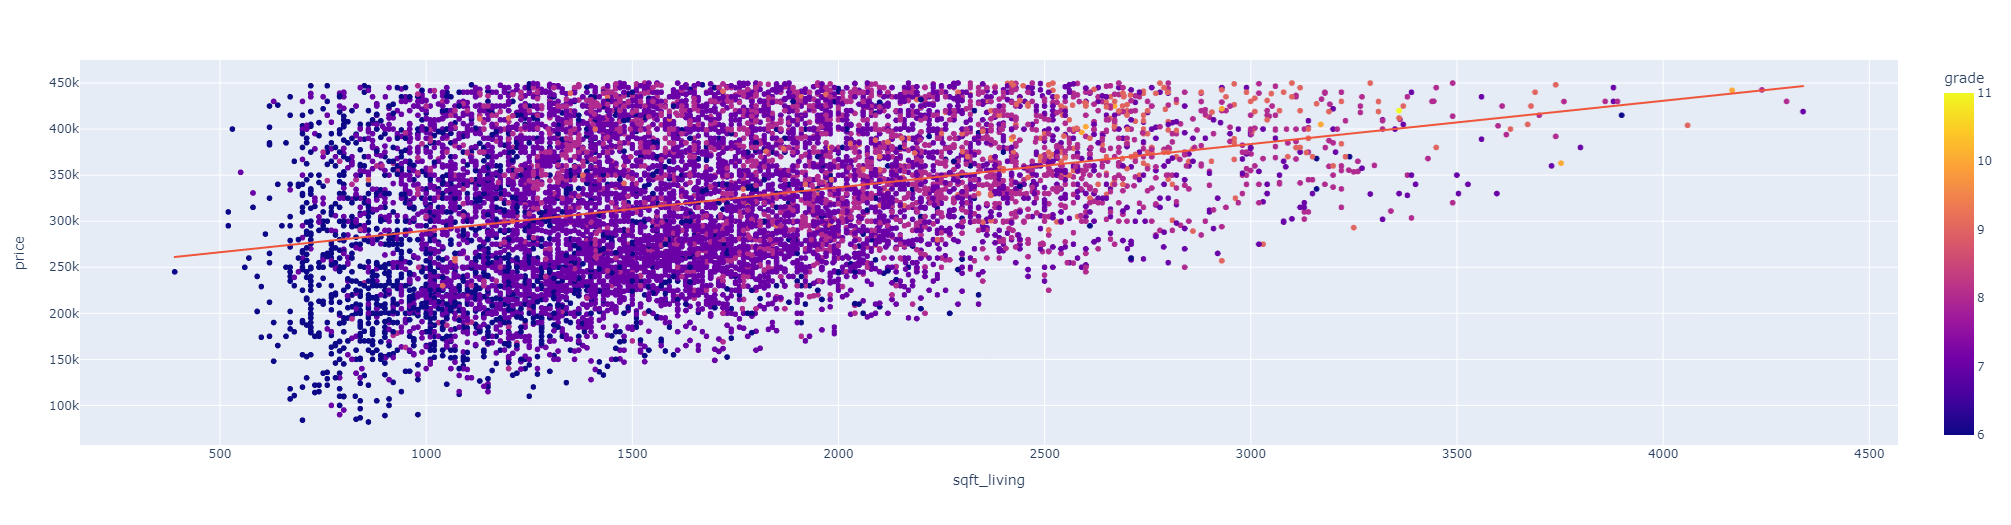

165 houses have prices below their 40th percentile but its condition is equal or grater to 8 (60th percentile) and sqft living is grater than 80th percentile.

In [ ]:
len(df[(df['price'] < 394000) & (df['sqft_living'] > 2673) & (df['grade'] >= 8)])

165

188 houses have prices below their 25th percentile but its condition is equal or grater to 8 (60th percentile) and sqft living is grater than 60th percentile.

In [ ]:
len(df[(df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['grade'] >= 8)])

188

333 houses have prices below their 25th percentile but its number of bedrooms is equal or grater to 4 (60th percentile) and sqft living is grater than 60th percentile.

In [ ]:
len(df[(df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['bedrooms'] >= 4)])

333

60 houses have prices below their 60th percentile but sqft living is grater than 90th percentile and grade is equal or grater to 90th percentile.

In [ ]:
len(df[(df['price'] < 500000) & (df['sqft_living'] > 3190) & (df['grade'] >= 9)])

60

17 houses have price below 50th percentile but sqft living grater that 80th percentile, num of bathrooms grater than 80th, num of bedrooms grater than 60th percentile and grade grater than 90th percentile.

In [ ]:
len(df[(df['price'] < 443600) & (df['sqft_living'] > 2680) & (df['grade'] >= 9) & (df['bedrooms'] >= 4) & (df['bathrooms'] > 2.5)])

17

There are 584 unique rows in these sets combined.

In [ ]:
len(df[(df['price'] < 394000) & (df['sqft_living'] > 2673) & (df['grade'] >= 8) | (df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['grade'] >= 8) | (df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['bedrooms'] >= 4) | (df['price'] < 500000) & (df['sqft_living'] > 3190) & (df['grade'] >= 9) | (df['price'] < 443600) & (df['sqft_living'] > 2680) & (df['grade'] >= 9) & (df['bedrooms'] >= 4) & (df['bathrooms'] > 2.5)])

584

In [ ]:
indexes_outliers = df[(df['price'] < 394000) & (df['sqft_living'] > 2673) & (df['grade'] >= 8) | (df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['grade'] >= 8) | (df['price'] < 320000) & (df['sqft_living'] > 2100) & (df['bedrooms'] >= 4) | (df['price'] < 500000) & (df['sqft_living'] > 3190) & (df['grade'] >= 9) | (df['price'] < 443600) & (df['sqft_living'] > 2680) & (df['grade'] >= 9) & (df['bedrooms'] >= 4) & (df['bathrooms'] > 2.5)].index

In [ ]:
indexes_all = df.index

In [ ]:
idx_keep = indexes_all.difference(indexes_outliers)

In [ ]:
df.loc[idx_keep]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,2014,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2015,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2014,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,2015,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,2014,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,2015,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,2014,402101.0,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,2015,400000.0,3,2.50,1600,2388,2.0,0,0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [ ]:
df = df.loc[idx_keep]

After data cleaning I'm left with 90.6% of original dataset.

I tried to be conservative when I was creating criterions for detecting outliers. The discrepancy needed to be at least 30% on both features if I were using 2 features. I made exceptions for samples with y over their 90th percentile. I was more strict creating criterions for them because top 10% of prices are much higher than other 90%.

In [ ]:
len(df)/21613 * 100

90.66302688196919

#Feature engineeiring 

Column waterfront is all 0 except for 163 rows so I'm going to drop it.

In [ ]:
df = df.drop('waterfront', axis='columns')

In [ ]:
len(df[df['yr_renovated'] > 0])

741

Column yr_renovated have year of renovation for houses that were renovated and 0 for these houses than weren't, it doesn't make sense because scale of this feature is ranging from 0 to 2000 something with only 793 rows with value greater than 0. I'm going to replace this column with years since last renovation column. Scale of this new feature will be appropriate as it will not favor old houses that were renovated. House built in 1970 and renovated in 2000 will have the same value as house built in 2000 and never renovated.

New column yr_since_renovation will be calculated as date - yr_built if yr_renovated == 0 and date - yr_renovated otherwise.

In [ ]:
yr_since_renovation = []
for index, row in df.iterrows():
  if row['yr_renovated'] == 0:
    yr_since_renovation.append(row['date'] - row['yr_built'])
  else:
    yr_since_renovation.append(row['date'] - row['yr_renovated'])

df['yr_since_renovation'] =  yr_since_renovation

df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
0,2014,221900.0,3,1.00,1180,5650,1.0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,59.0
1,2014,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,23.0
2,2015,180000.0,2,1.00,770,10000,1.0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,82.0
3,2014,604000.0,4,3.00,1960,5000,1.0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,49.0
4,2015,510000.0,3,2.00,1680,8080,1.0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,28.0


Let's look at histogram and boxplot of this new column.


In [ ]:
colname = 'yr_since_renovation'
fig = make_subplots(rows=1, cols=2, subplot_titles=(f'{colname} distribiution', f'{colname} boxplot'))
fig.add_trace(go.Histogram(x=df[colname], nbinsx=15), row=1, col=1)
fig.add_trace(go.Box(x=df[colname]), row=1, col=2)
fig.show()

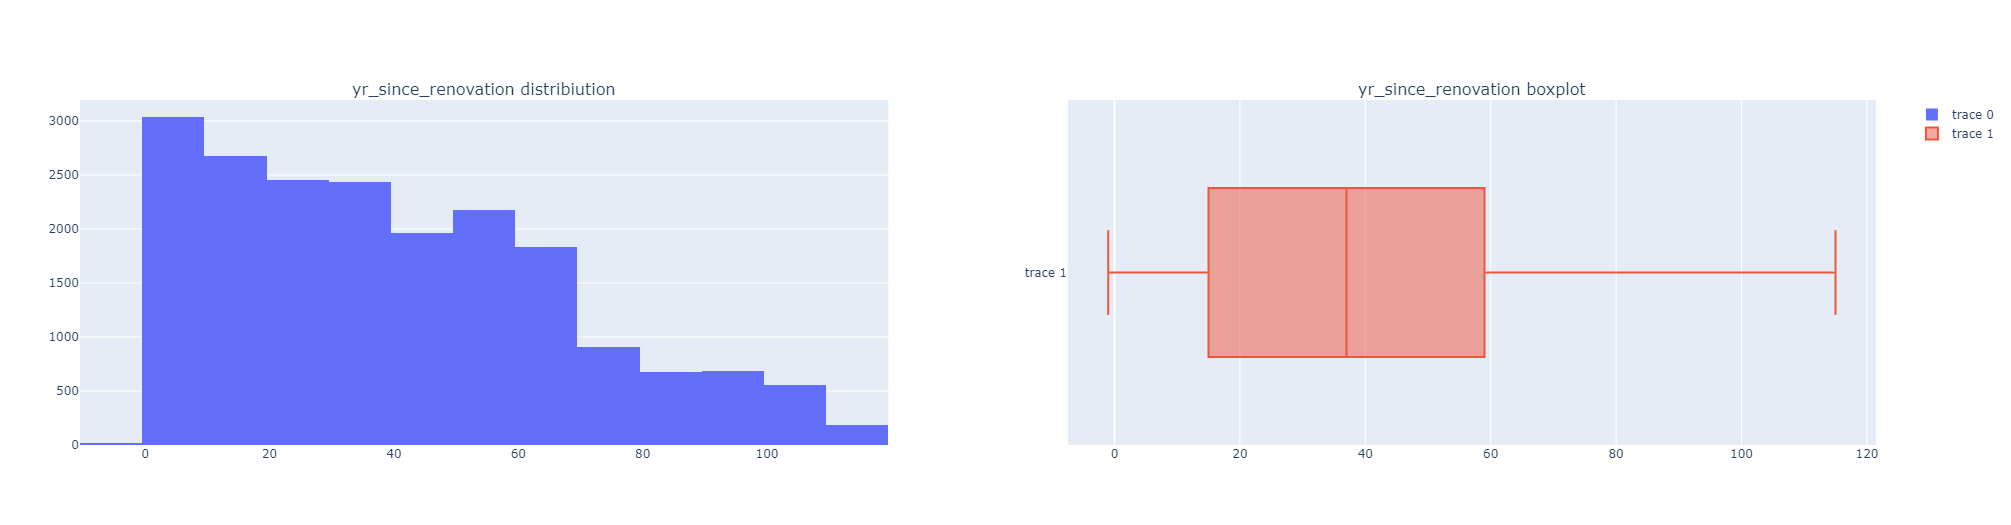

As can be seen on histogram there are some examples where yr_since_renovation is negative and it shouldn't be so lets look into that.

In [ ]:
df[df['yr_since_renovation'] < 0]

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
1763,2014,597326.0,4,4.00,3570,8250,2.0,0,3,10,2860,710,2015,0,98040,47.5784,-122.226,2230,10000,-1.0
2295,2014,585000.0,5,2.75,2350,4178,1.5,0,3,8,1520,830,1922,2015,98112,47.6388,-122.300,1920,4178,-1.0
2687,2014,385195.0,1,1.00,710,6000,1.5,0,3,6,710,0,2015,0,98144,47.5756,-122.316,1440,4800,-1.0
7526,2014,614285.0,5,2.75,2730,6401,2.0,0,3,8,2730,0,2015,0,98072,47.7685,-122.160,2520,6126,-1.0
8039,2014,455000.0,2,1.50,1200,1259,2.0,0,3,8,1000,200,2015,0,98144,47.6001,-122.298,1320,1852,-1.0
11599,2014,850000.0,4,3.25,3090,6744,2.0,4,3,9,3090,0,1923,2015,98177,47.7680,-122.388,2020,6656,-1.0
14489,2014,500000.0,2,2.25,1570,1269,2.0,0,3,9,1280,290,2015,0,98199,47.6514,-122.385,1570,6000,-1.0
14859,2014,805000.0,5,2.50,4600,19831,1.0,3,3,9,2300,2300,1956,2015,98177,47.7608,-122.378,2890,19831,-1.0
15687,2014,825000.0,3,2.50,3400,38400,1.0,4,3,8,1870,1530,1955,2015,98177,47.7611,-122.372,3400,24338,-1.0
17098,2014,350000.0,3,2.00,1380,3600,3.0,0,3,8,1380,0,2015,0,98122,47.6074,-122.305,1480,3600,-1.0


Negative values appeared because of incorrect data. Some houses built in 2015 were sold in 2014 which is possible, pepople buy properties from developers before they are finished but I don't know if it is the case here. Since it's only 18 rows I'm just going to drop them.

In [ ]:
df = df[df['yr_since_renovation'] > -1]

Neither of yr_renovated and date are going to be usefull anymore so lets drop them.

In [ ]:
df.drop(['yr_renovated', 'date'], axis=1, inplace=True)

There is positive corelation of 0.42 between condition and years since renovation which is strange because as time since renovation increases condition also increases. Let's look into that matter.

In [ ]:
df.corr()['yr_since_renovation']

price                 -0.144101
bedrooms              -0.167155
bathrooms             -0.562780
sqft_living           -0.357735
sqft_lot              -0.069673
floors                -0.526830
view                   0.023769
condition              0.426514
grade                 -0.476913
sqft_above            -0.455109
sqft_basement          0.127425
yr_built              -0.917442
zipcode                0.327993
lat                    0.134360
long                  -0.404219
sqft_living15         -0.344771
sqft_lot15            -0.074097
yr_since_renovation    1.000000
Name: yr_since_renovation, dtype: float64

From this scatter plot I see that there are some houses renovated 115 years ago and their condition is 5 which seems a bit suspicious to me.

In [ ]:
fig = px.scatter(df[df['price'] < 1e6], x="yr_since_renovation", y="condition", color='price')
fig.show()

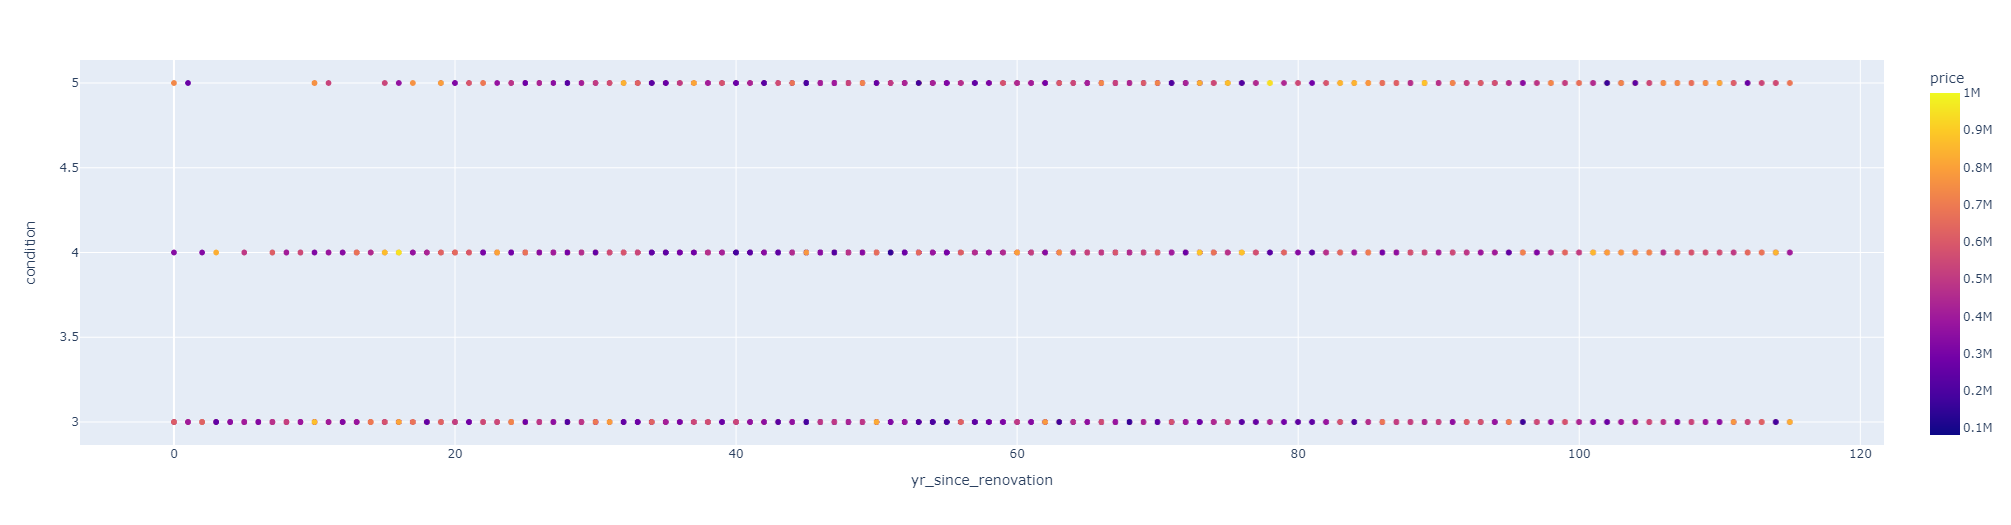

There are 2095 houses in this dataset that were renovated or built 80 years ago and 1252 of them have condition 4 or grater. In my opinion it's strange and makes one of condition or years since renovation unreliable, either renovations weren't recorded or condition scoring wasn't very conservative.

In [ ]:
len(df[df['yr_since_renovation'] > 80])

2095

In [ ]:
df[((df['yr_since_renovation'] > 80) & (df['condition'] >= 4))]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
12,310000.0,3,1.00,1430,19901,1.5,0,4,7,1430,0,1927,98028,47.7558,-122.229,1780,12697,87.0
17,485000.0,4,1.00,1600,4300,1.5,0,4,7,1600,0,1916,98103,47.6648,-122.343,1610,4300,98.0
18,189000.0,2,1.00,1200,9850,1.0,0,4,7,1200,0,1921,98002,47.3089,-122.210,1060,5095,93.0
27,667000.0,3,1.00,1400,1581,1.5,0,5,8,1400,0,1909,98112,47.6221,-122.314,1860,3861,105.0
32,687500.0,4,1.75,2330,5000,1.5,0,4,7,1510,820,1929,98117,47.6823,-122.368,1460,5000,85.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19620,850000.0,5,3.00,3900,5250,1.5,1,5,8,2620,1280,1931,98116,47.5577,-122.389,1950,5700,83.0
20017,290000.0,1,0.75,740,1284,1.0,0,4,6,740,0,1928,98107,47.6741,-122.406,1430,3988,86.0
20384,394000.0,3,2.00,1160,3441,1.0,0,4,6,580,580,1930,98136,47.5314,-122.392,1160,4000,84.0
20583,749000.0,4,2.75,2700,6000,2.0,0,4,8,2100,600,1910,98116,47.5860,-122.383,2050,5400,104.0


Now let's look into bathroom column.

In [ ]:
bathroom_df = df[df['bathrooms'] % 0.5 != 0]
bathroom_df

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
1,538000.0,3,2.25,2570,7242,2.0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,23.0
6,257500.0,3,2.25,1715,6819,2.0,0,3,7,1715,0,1995,98003,47.3097,-122.327,2238,6819,19.0
13,400000.0,3,1.75,1370,9680,1.0,0,4,7,1370,0,1977,98074,47.6127,-122.045,1370,10208,37.0
20,385000.0,4,1.75,1620,4980,1.0,0,4,7,860,760,1947,98133,47.7025,-122.341,1400,4980,67.0
24,329000.0,3,2.25,2450,6500,2.0,0,4,8,2450,0,1985,98030,47.3739,-122.172,2200,6865,29.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21597,1575000.0,4,3.25,3410,10125,2.0,0,3,10,3410,0,2007,98040,47.5653,-122.223,2290,10125,8.0
21600,1537000.0,5,3.75,4470,8088,2.0,0,3,11,4470,0,2008,98004,47.6321,-122.200,2780,8964,6.0
21602,224000.0,3,1.75,1500,11968,1.0,0,3,6,1500,0,2014,98010,47.3095,-122.002,1320,11303,0.0
21610,402101.0,2,0.75,1020,1350,2.0,0,3,7,1020,0,2009,98144,47.5944,-122.299,1020,2007,5.0


In [ ]:
len(bathroom_df) / len(df) * 100

33.34014300306435

One third of the data have values in bathrooms column that it shouldn't have. These values probably aren't far off from the real value but I can't leave them as they are. I'm going to round values containing quarters to nearest integers.

In [ ]:
df = df[df['bathrooms'] % 0.5 == 0]

In [ ]:
bathroom_df['bathrooms'] = np.round(bathroom_df['bathrooms'])

In [ ]:
df = pd.concat([df, bathroom_df])

In [ ]:
df.sort_index(inplace=True)

Zip code column has 70 unique values I could one hot encode it but that would add too much dimensions to the data. Instead I'm going to cluster the data into 20 categories and drop zipcode. I will use k-means clustering on only latitude and longitide columns so that each cluster will be a 'neighborhood'. I'm going to use this cluster column instead of lat and long columns for certain types of models and for some types I will use only coordinates, more on that later.

In [ ]:
df['zipcode'].value_counts()

98052    569
98103    566
98038    556
98115    538
98034    528
        ... 
98102     80
98109     75
98024     72
98148     49
98039      9
Name: zipcode, Length: 70, dtype: int64

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
kmeans_pipeline = Pipeline_sk([
                        ('scaler', StandardScaler()),
                        ('k_means', KMeans(n_clusters=20, random_state=0))
])

In [ ]:
kmeans_pipeline.fit(df[['lat', 'long']])

Pipeline(steps=[('scaler', StandardScaler()),
                ('k_means', KMeans(n_clusters=20, random_state=0))])

I'm saving kmeans clustering object because it will be necessary to predict on unseen data.

In [ ]:
file = open('/content/drive/MyDrive/regression project/kmeans_pipeline.pkl', 'wb')
pickle.dump(kmeans_pipeline, file)

In [ ]:
file = open('/content/drive/MyDrive/regression project/kmeans_pipeline.pkl', 'rb')
kmeans_pipeline = pickle.load(file)

In [ ]:
clusters = kmeans_pipeline.predict(df[['lat', 'long']])

In [ ]:
df['cluster'] = clusters
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,cluster
0,221900.0,3,1.0,1180,5650,1.0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,59.0,8
1,538000.0,3,2.0,2570,7242,2.0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,23.0,19
2,180000.0,2,1.0,770,10000,1.0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,82.0,3
3,604000.0,4,3.0,1960,5000,1.0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,49.0,0
4,510000.0,3,2.0,1680,8080,1.0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,28.0,4


In [ ]:
fig = px.scatter(df, x="lat", y="long", color='cluster')
fig.show()

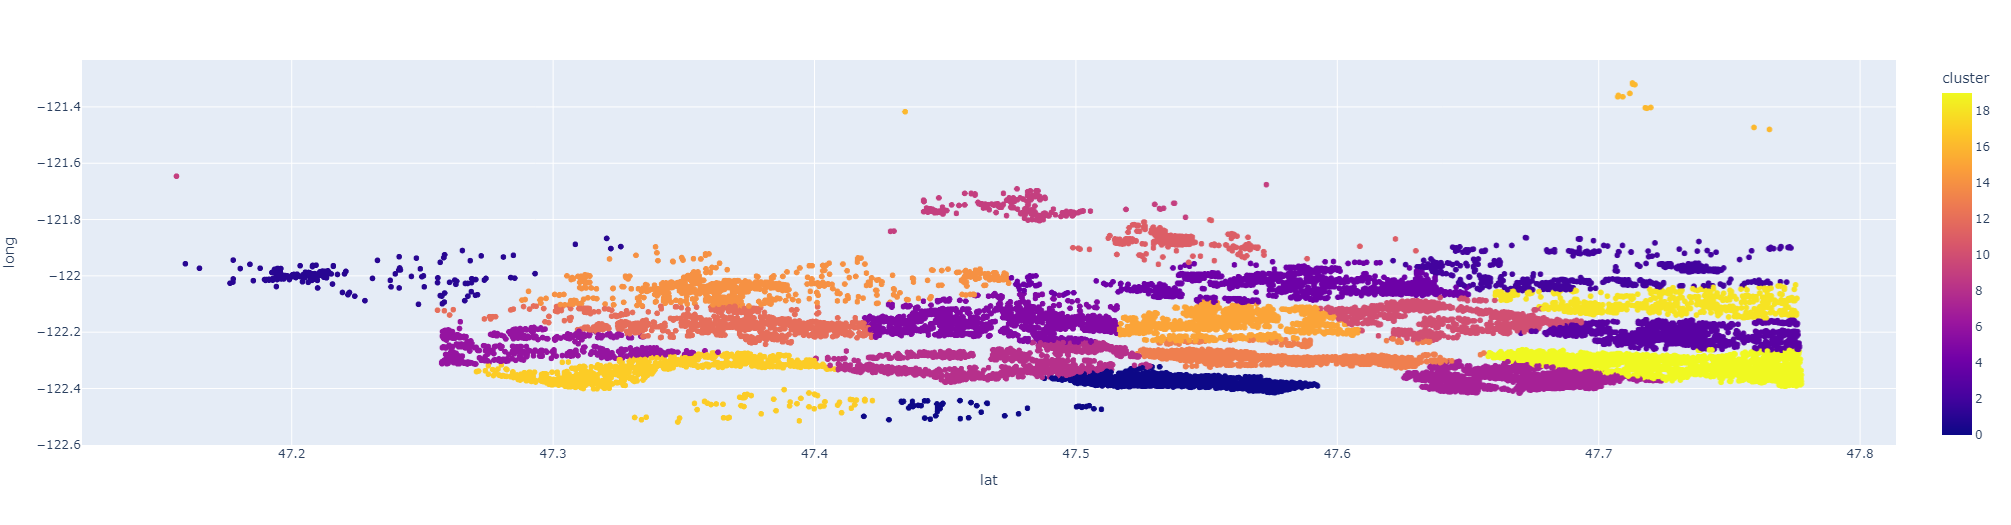

In [ ]:
clusters_info = pd.DataFrame({'mean_price':df.groupby(['cluster']).mean()['price'], 'std_price':df.groupby(['cluster']).std()['price']})

Mean price varies for different clusters and standard deviations of prices for these clusters in most cases isn't that big, this means that 'neighborhood' clusters will probably be beneficial for predictions.

In [ ]:
clusters_info

,mean_price,std_price
cluster,,
0,454655.424200,195685.178317
1,316028.672646,118241.455107
2,570214.186728,222795.779527
3,514455.959167,201652.092259
4,663052.494278,214781.150334
5,368830.019217,124670.015873
6,274064.032847,93300.838962
7,604401.887331,206136.900499
8,312334.506964,162754.636137


#Discussion on training strategies

After data cleaning and feature engineering I'm left with 18 features. Condition, grade and view are ordinal variables which means they are categorical but there is a natural order for them. Cluster is categorical and all other are numerical. Categorical features need to be one hot encoded even if their dtype is numerical, it must be done because there is no reasonable ordering of these categories.

If I don't want ordinal variables relationship with price to be linear when using linear regression and linear SVR I need to one hot encode them. Linear relationship means that difference between grade 6 and 7 is the same as difference between grade 7 and 8. With one hot encoding each level of grade will have it's own coefficient and therefore difference between grade 6 and 8 don't have to be twice as much as difference between 6 and 7.

For KNeighborsRegressor it's not obvious if ordinal features should be one hot encoded or not. If I one hot encode them distance between some row x1 with grade 6 and two identical rows except for grade, x2 with grade 5 and x3 with grade 9, would be the same. On the other hand if I leave these features in their numerical form influence on distance from x3's grade would be 3 times larger than x2's grade influence and that might not be an ideal solution. Fortunately KNR is not computationally expensive so I can test both approaches and see which brings better results.

For SupportVectorRegressor and XGBRegressor I'm not going to one hot encode these features. SVR operates in higher dimension than original data when kernel trick is being used so it's capable of producing non linear regression line. XGBR splits data into buckets so it's better to leave ordinal features as they are because xgbr will be able to for example select all rows with grade >= 7 and then restrain them to be <=9 if necessary, with one hot encoded data that would be impossible.

I will use cluster column only for Linear and KNeighbors regression. Linear regression will then be able to assign different coefficient for each geographical cluster. KNR might work better with raw coordinates but since it's not computationaly expensive I'm going to try using cluster column as well. SVR and XGBR are constructed in a way that will probably yeld better results when they are fitted with raw coordinates than geo clusters. Training these models with both these columns woudn't be a bad idea but it's adding too much dimensionality to the data, that's why I'm not going to do it.

In [ ]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15,yr_since_renovation,cluster
0,221900.0,3,1.0,1180,5650,1.0,0,3,7,1180,0,1955,98178,47.5112,-122.257,1340,5650,59.0,8
1,538000.0,3,2.0,2570,7242,2.0,0,3,7,2170,400,1951,98125,47.7210,-122.319,1690,7639,23.0,19
2,180000.0,2,1.0,770,10000,1.0,0,3,6,770,0,1933,98028,47.7379,-122.233,2720,8062,82.0,3
3,604000.0,4,3.0,1960,5000,1.0,0,5,7,1050,910,1965,98136,47.5208,-122.393,1360,5000,49.0,0
4,510000.0,3,2.0,1680,8080,1.0,0,3,8,1680,0,1987,98074,47.6168,-122.045,1800,7503,28.0,4


In [ ]:
df['grade'].value_counts()

7     8603
8     5509
9     2241
6     1939
10     955
11     287
12      45
13       1
Name: grade, dtype: int64

I'm going to delete this one row with grade 13 because it will add one dimension to all the data when one hot encoded.

In [ ]:
df = df[df['grade'] < 13]

In [ ]:
df['view'].value_counts()

0    17936
2      811
3      390
1      271
4      171
Name: view, dtype: int64

I decided to drop condition column because is has almost no correlation with price and as we saw above with years since renovation case in my opinion it's unreliable.

In [ ]:
df['condition'].value_counts()

3    12925
4     5160
5     1494
Name: condition, dtype: int64

In [ ]:
df = df.drop('condition', axis='columns')

I'm also going to drop sqft_living because it's the same information as sqft_above and sqft_basement added up. 

In [ ]:
df = df.drop('sqft_living', axis='columns')

In [ ]:
df_clusters = df.drop(['zipcode', 'lat', 'long'], axis='columns')
df_coords = df.drop(['zipcode', 'cluster'], axis='columns')

In [ ]:
X_clu = df_clusters.drop('price', axis='columns')
y = df_clusters['price']
X_co = df_coords.drop('price', axis='columns')

In [ ]:
X_clu.to_csv('/content/drive/MyDrive/regression project/X_clu.csv', index=False)
y.to_csv('/content/drive/MyDrive/regression project/y_clu.csv', index=False)
X_co.to_csv('/content/drive/MyDrive/regression project/X_co.csv', index=False)

In [ ]:
X_clu.head()

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,yr_since_renovation,cluster
0,3,1.0,5650,1.0,0,7,1180,0,1955,1340,5650,59.0,8
1,3,2.0,7242,2.0,0,7,2170,400,1951,1690,7639,23.0,19
2,2,1.0,10000,1.0,0,6,770,0,1933,2720,8062,82.0,3
3,4,3.0,5000,1.0,0,7,1050,910,1965,1360,5000,49.0,0
4,3,2.0,8080,1.0,0,8,1680,0,1987,1800,7503,28.0,4


In [ ]:
X_co

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
0,3,1.0,5650,1.0,0,7,1180,0,1955,47.5112,-122.257,1340,5650,59.0
1,3,2.0,7242,2.0,0,7,2170,400,1951,47.7210,-122.319,1690,7639,23.0
2,2,1.0,10000,1.0,0,6,770,0,1933,47.7379,-122.233,2720,8062,82.0
3,4,3.0,5000,1.0,0,7,1050,910,1965,47.5208,-122.393,1360,5000,49.0
4,3,2.0,8080,1.0,0,8,1680,0,1987,47.6168,-122.045,1800,7503,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,3,2.5,1131,3.0,0,8,1530,0,2009,47.6993,-122.346,1530,1509,5.0
21609,4,2.5,5813,2.0,0,8,2310,0,2014,47.5107,-122.362,1830,7200,1.0
21610,2,1.0,1350,2.0,0,7,1020,0,2009,47.5944,-122.299,1020,2007,5.0
21611,3,2.5,2388,2.0,0,8,1600,0,2004,47.5345,-122.069,1410,1287,11.0


#Error analysis

Now I'm going to train linear regression model, plot its coefficient and then perform error analysis.

One hot encoding and scaling will be done on the fly for each grid search fold by columntransformer.


In [ ]:
one_hot_and_scale = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), [4, 5, 12]),
    ('scaler', StandardScaler(), [1, 2, 3, 6, 7, 8, 9, 10, 11])
], remainder='passthrough')

In [ ]:
test_sample = one_hot_and_scale.fit_transform(X_clu)
len(test_sample[0])

42

In [ ]:
test_sample[0]

array([ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -1.53388356, -0.27197512, -0.90391428,
       -0.73082278, -0.65442159, -0.58395427, -0.9299899 , -0.27795044,
        0.65887468,  3.        ])

In [ ]:
x_cluster_feature_names =  [f'view_{i}' for i in range(len(X_clu['view'].unique()))] + [f'grade_{i+6}' for i in range(len(X_clu['grade'].unique()))] + [f'cluster_{i}' for i in range(20)] + list(X_clu.columns[:4]) + list(X_clu.columns[6:-1])

In [ ]:
encoded_scaled_df = pd.DataFrame(test_sample, columns = x_cluster_feature_names)

In [ ]:
lr = LinearRegression_sk()

In [ ]:
lr_pipeline = Pipeline_sk([
                        ('one_hot_and_scale', one_hot_and_scale),
                        ('linear_regression', lr)
])

In [ ]:
parameters = {
    'linear_regression__fit_intercept':[True, False]
}

In [ ]:
lr_grid = GridSearchCV_sk(lr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
lr_grid.fit(X_clu, y)

In [ ]:
lr_grid.best_score_ *-1

114176.30043590526

In [ ]:
lr_grid.best_params_

{'linear_regression__fit_intercept': False}

In [ ]:
coeficients = lr_grid.best_estimator_.named_steps['linear_regression'].coef_

In [ ]:
encoded_scaled_df.describe().T[-10:]

,count,mean,std,min,25%,50%,75%,max
bedrooms,19579.0,2.671022e-16,1.000026,-2.916536,-0.842557,-0.151231,0.540095,3.996727
bathrooms,19579.0,8.709855e-18,1.000026,-0.437257,-0.292885,-0.210437,-0.115714,13.833077
sqft_lot,19579.0,-1.858102e-16,1.000026,-0.903914,-0.903914,-0.903914,0.948476,2.800866
floors,19579.0,-1.103248e-16,1.000026,-1.740513,-0.730823,-0.283492,0.508923,6.247542
sqft_above,19579.0,-3.774271e-17,1.000026,-0.654422,-0.654422,-0.654422,0.599817,6.090071
sqft_basement,19579.0,-2.926511e-15,1.000026,-2.486974,-0.653155,0.142653,0.869261,1.492068
yr_built,19579.0,1.683905e-16,1.000026,-2.349127,-0.718854,-0.221175,0.532883,5.781128
sqft_living15,19579.0,5.806570e-18,1.000026,-0.484822,-0.301539,-0.197875,-0.097936,13.530684
sqft_lot15,19579.0,2.322628e-17,1.000026,-1.423769,-0.894283,-0.117704,0.658875,2.635621
yr_since_renovation,19579.0,3.343429e+00,0.868654,0.000000,3.000000,3.000000,4.000000,8.000000


I made a good choice one hot encoding view and grade because growth for their coefficients is not linear.

In [ ]:
fig = px.bar(x=x_cluster_feature_names, y=coeficients)
fig.show()

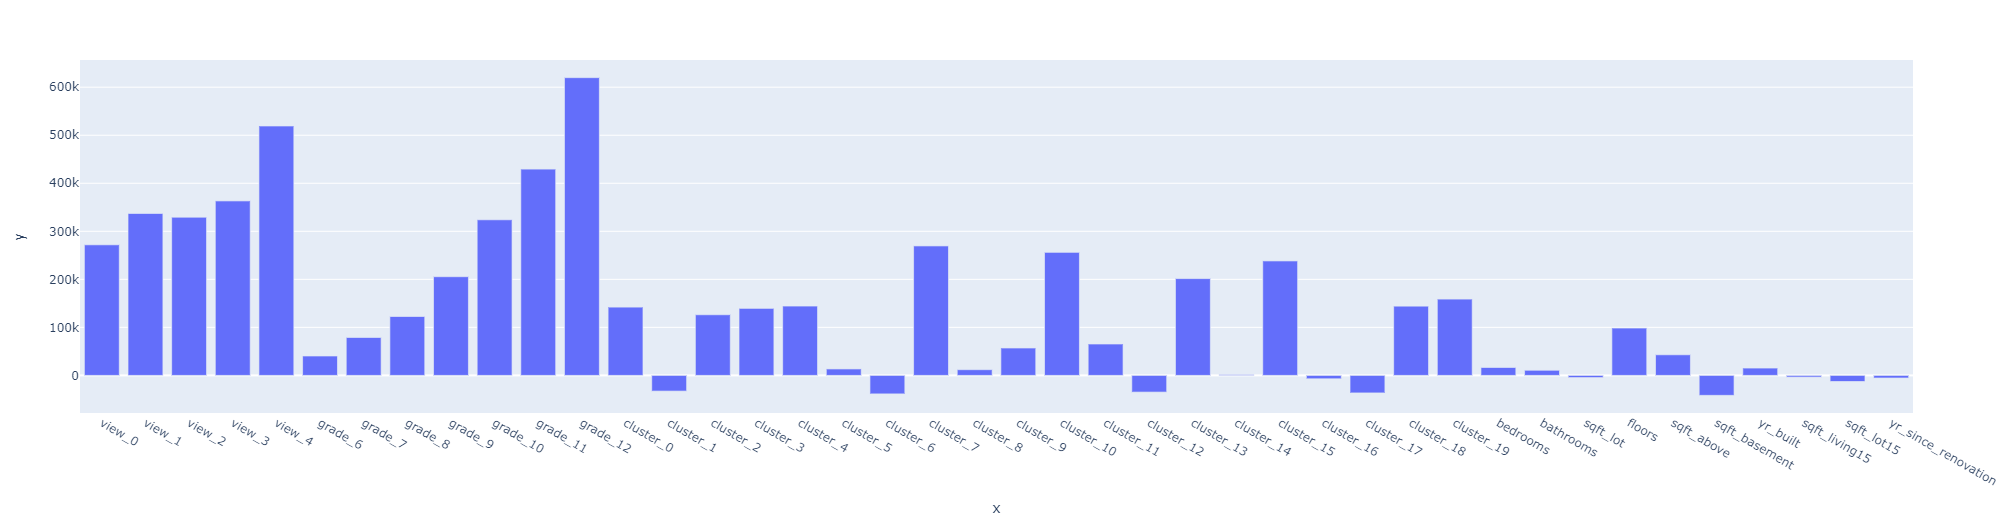

In [ ]:
np.round(y.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count      19579.0
mean      503762.0
std       253549.0
min        82000.0
25%       325000.0
50%       450000.0
75%       620000.0
90%       809960.0
95%       950000.0
99%      1496100.0
max      1899000.0
Name: price, dtype: float64

RMSE of 114k with mean y of 500k and std of 253k is acceptable. Now to visualize models performance I'm going to create train test splits, train single lr model on it, predict, calculate errors and plot them. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_clu, y, test_size=0.3, random_state=42)

In [ ]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('one_hot_and_scale',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot',
                                                  OneHotEncoder(sparse=False),
                                                  [4, 5, 12]),
                                                 ('scaler', StandardScaler(),
                                                  [1, 2, 3, 6, 7, 8, 9, 10,
                                                   11])])),
                ('linear_regression', LinearRegression())])

In [ ]:
preds = np.array(lr_pipeline.predict(X_test))
preds = np.round(preds)

In [ ]:
results = pd.DataFrame()
results['price'] = y_test.copy()
results['prediction'] = preds

In [ ]:
results['error'] = results['price'] - results['prediction']
results['squared_error'] = np.power(results['error'], 2)
results['abs_error'] = np.absolute(results['error'])

In [ ]:
results = results.sort_values('squared_error' , ascending=False)
top_250_lr = results[:250]
np.round(top_250_lr.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]), 0).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
price,250.0,9.776990e+05,4.512800e+05,1.540000e+05,6.237250e+05,8.700000e+05,1.379425e+06,1.665500e+06,1.737750e+06,1.806448e+06,1.855000e+06
prediction,250.0,8.714520e+05,2.758140e+05,1.356800e+05,6.476160e+05,8.839680e+05,1.079168e+06,1.220608e+06,1.281126e+06,1.431785e+06,1.530112e+06
error,250.0,1.062480e+05,3.470800e+05,-4.875120e+05,-2.631560e+05,2.575600e+05,3.465320e+05,4.898410e+05,6.019250e+05,8.278620e+05,9.512640e+05
squared_error,250.0,1.312712e+11,1.235625e+11,5.621072e+10,6.715720e+10,8.312781e+10,1.302287e+11,2.399443e+11,3.623293e+11,6.854080e+11,9.049032e+11
abs_error,250.0,3.396410e+05,1.264080e+05,2.370880e+05,2.591470e+05,2.883160e+05,3.608720e+05,4.898410e+05,6.019250e+05,8.278620e+05,9.512640e+05


In [ ]:
top250_x_lr = X_test.copy().loc[top_250_lr.index]

In [ ]:
top250_x_lr = pd.concat([top250_x_lr, top_250_lr], axis=1)

In [ ]:
top250_x_lr['top_250'] = 1

In [ ]:
bottom_rest_lr = results[250:]
bottom_rest_lr.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).T

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
price,5624.0,4.875206e+05,2.227681e+05,89000.0,325000.0,4.450000e+05,6.050000e+05,7.786100e+05,8.900000e+05,1.200000e+06,1.822500e+06
prediction,5624.0,4.951608e+05,2.200180e+05,76800.0,340992.0,4.707840e+05,6.047360e+05,7.693824e+05,9.082112e+05,1.205642e+06,1.735424e+06
error,5624.0,-7.640198e+03,8.596750e+04,-236432.0,-62797.0,-6.092000e+03,4.605800e+04,9.964720e+04,1.347172e+05,2.068942e+05,2.362240e+05
squared_error,5624.0,7.447470e+09,1.060699e+10,576.0,656486896.0,2.961972e+09,9.484716e+09,2.171945e+10,3.228656e+10,4.860478e+10,5.590009e+10
abs_error,5624.0,6.778095e+04,5.342022e+04,24.0,25622.0,5.442400e+04,9.738950e+04,1.473752e+05,1.796846e+05,2.204649e+05,2.364320e+05


In [ ]:
bottom_rest_x_lr = X_test.loc[bottom_rest_lr.index]
bottom_rest_x_lr = pd.concat([bottom_rest_x_lr, bottom_rest_lr], axis=1)
bottom_rest_x_lr['top_250'] = 0

In [ ]:
df_error_lr = pd.concat([top250_x_lr, bottom_rest_x_lr])

In [ ]:
df_error_lr.sample(10)

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,yr_since_renovation,cluster,price,prediction,error,squared_error,abs_error,top_250
17277,3,2.0,8917,1.0,0,7,1230,0,1966,1420,7938,49.0,5,220000.0,244992.0,-24992.0,6.246001e+08,24992.0,0
769,3,2.5,12750,2.0,0,10,2360,810,1995,2970,13125,19.0,17,405000.0,679424.0,-274424.0,7.530853e+10,274424.0,1
5926,3,2.5,7202,2.0,0,8,2980,0,1999,2430,7280,16.0,10,817250.0,745984.0,71266.0,5.078843e+09,71266.0,0
12838,3,2.5,15985,1.0,0,8,1540,450,1964,2470,10125,50.0,10,542000.0,654848.0,-112848.0,1.273467e+10,112848.0,0
355,4,2.0,7475,1.0,0,7,1100,1100,1955,1600,5766,59.0,13,375000.0,546304.0,-171304.0,2.934506e+10,171304.0,0
12669,4,2.0,103672,1.0,0,7,2030,0,1969,1560,325393,45.0,1,335000.0,289792.0,45208.0,2.043763e+09,45208.0,0
12375,4,3.0,213879,2.0,0,8,2830,0,1987,2250,213008,27.0,12,549900.0,488704.0,61196.0,3.744950e+09,61196.0,0
6569,4,1.5,5100,1.0,0,7,1320,460,1953,1880,5100,62.0,19,580000.0,459264.0,120736.0,1.457718e+10,120736.0,0
4389,3,2.0,8625,1.0,0,8,1320,320,1987,1770,9476,28.0,10,580000.0,563200.0,16800.0,2.822400e+08,16800.0,0
225,3,2.0,7500,1.0,0,7,1250,0,1942,1280,7392,72.0,0,390000.0,397312.0,-7312.0,5.346534e+07,7312.0,0


As can be seen on the plot below linear regression clearly doesn't do a good job predicting prices for the most expensive houses.

When you hover over these individual points more info about them is displayed. Most of the rows with error in the top 250 I've looked at seems to have a large discrepancy between their percentile of price and it's percentiles of features like sqft_above, bedrooms ect. I've tried to detect and delete these rows, maybe I wasn't strict enough when I was inventing the criteria for their detection or maybe maybe they aren't outliers and different model will do a better job. 

In [ ]:
fig = px.scatter(df_error_lr, x='price', y='error', color='top_250', hover_data=['price', 'prediction', 'sqft_above', 'grade', 'sqft_lot', 'bathrooms', 'bedrooms'])
fig.show()

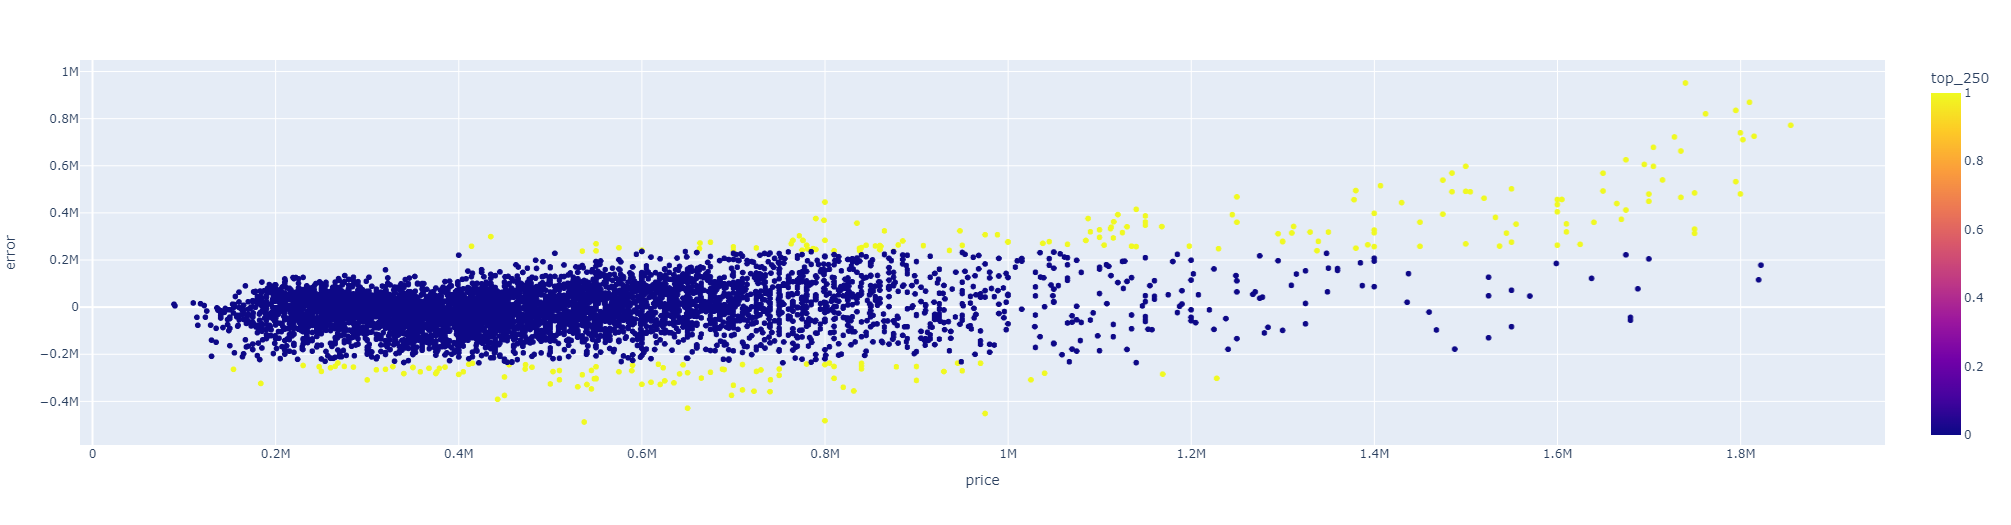

In [ ]:
fig = px.scatter(df_error_lr, x='sqft_above', y='error', color='price', hover_data=['price', 'prediction', 'sqft_above', 'grade', 'sqft_lot', 'bathrooms', 'bedrooms', 'top_250'])
fig.show()

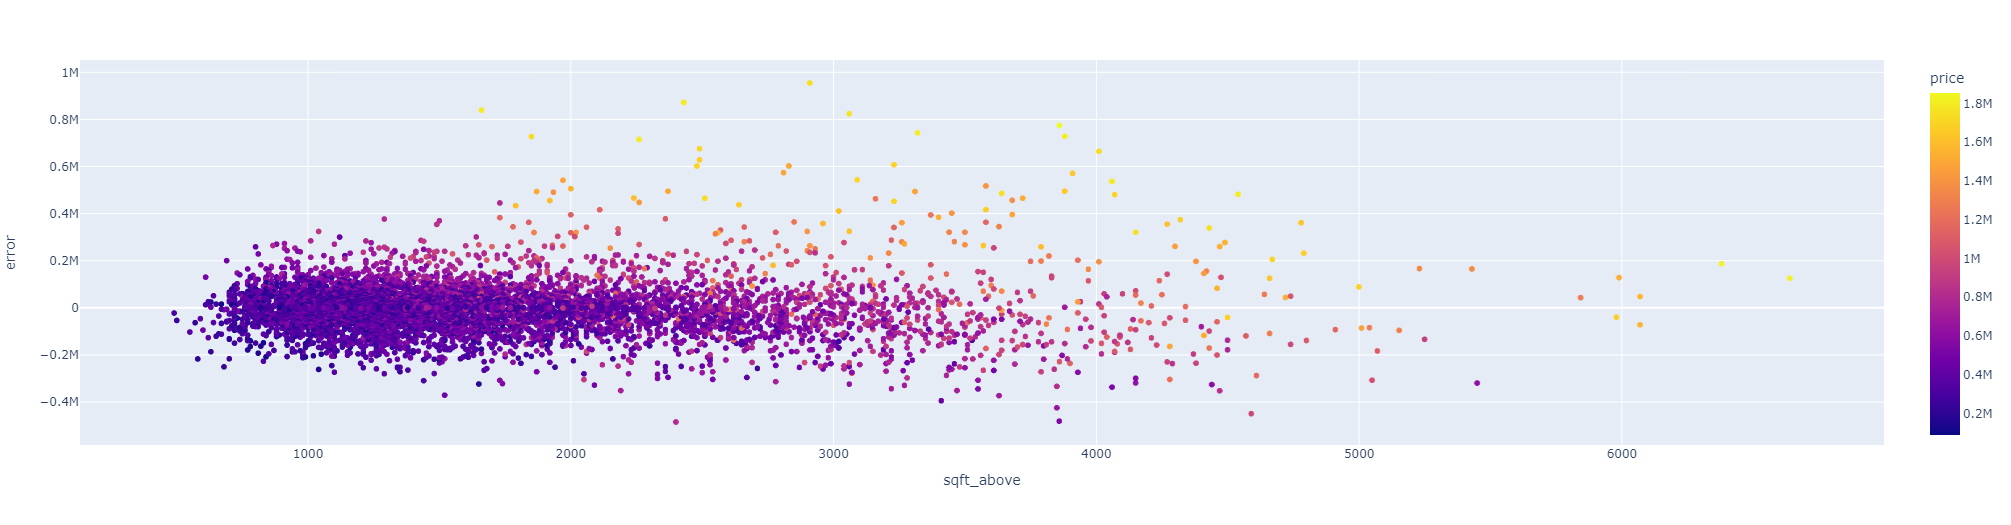

Now I will train XGBRegressor to visualize it's performance and to see if it has the highest errors on the same samples as linear regression did.

In [ ]:
XGBR = XGBRegressor()

In [ ]:
one_hot_only_cluster = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), [12])
], remainder='passthrough')

In [ ]:
xgbr_pipeline = Pipeline_sk([
                        ('one_hot_enc_cluster', one_hot_only_cluster),
                        ('XGBRegressor', XGBR)
])

In [ ]:
xgbr_pipeline.fit(X_train, y_train)

In [ ]:
preds = xgbr_pipeline.predict(X_test)

In [ ]:
results = pd.DataFrame()
results['price'] = y_test.copy()
results['prediction'] = preds

In [ ]:
results['error'] = results['price'] - results['prediction']
results['squared_error'] = np.power(results['error'], 2)
results['abs_error'] = np.absolute(results['error'])

In [ ]:
results = results.sort_values('squared_error' , ascending=False)
top_250_xgbr = results[:250]
np.round(top_250_xgbr.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

,price,prediction,error,squared_error,abs_error
count,250.0,250.0,250.0,2.500000e+02,250.0
mean,990254.0,878290.0,111965.0,1.237723e+11,333356.0
std,430755.0,301179.0,334190.0,9.926309e+10,112680.0
min,130000.0,317090.0,-582884.0,5.333455e+10,230943.0
25%,699999.0,602446.0,-255042.0,6.487855e+10,254713.0
50%,870000.0,895004.0,254497.0,8.253687e+10,287292.0
75%,1345375.0,1128213.0,336304.0,1.461243e+11,382261.0
90%,1677000.0,1262037.0,476648.0,2.417959e+11,491725.0
95%,1750000.0,1345461.0,554291.0,3.155823e+11,561746.0
99%,1817550.0,1462105.0,737847.0,5.457916e+11,737847.0


In [ ]:
top250_x_xgbr = X_test.loc[top_250_xgbr.index]

In [ ]:
top250_x_xgbr = pd.concat([top250_x_xgbr, top_250_xgbr], axis=1)
top250_x_xgbr['top_250'] = 1
bottom_rest_xgbr = results[250:]
bottom_rest_x_xgbr = X_test.loc[bottom_rest_xgbr.index]
bottom_rest_x_xgbr = pd.concat([bottom_rest_x_xgbr, bottom_rest_xgbr], axis=1)
bottom_rest_x_xgbr['top_250'] = 0
bottom_rest_x_xgbr

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,yr_since_renovation,cluster,price,prediction,error,squared_error,abs_error,top_250
4358,2,1.0,6263,1.0,1,6,960,0,1942,1460,6054,72.0,10,660000.0,4.293678e+05,230632.25000,5.319123e+10,230632.25000,0
4439,3,2.5,18505,1.0,4,10,2530,1140,1983,2920,20000,31.0,19,1250000.0,1.019393e+06,230606.56250,5.317939e+10,230606.56250,0
13536,3,2.0,12180,1.0,0,7,1670,940,1918,1520,12180,96.0,0,310000.0,5.402089e+05,-230208.87500,5.299613e+10,230208.87500,0
8355,2,2.0,5100,1.0,0,6,580,1160,1915,1440,5100,100.0,0,205000.0,4.345548e+05,-229554.75000,5.269538e+10,229554.75000,0
14102,4,3.0,5000,2.0,0,8,1370,680,1987,1720,5000,27.0,13,750000.0,5.207591e+05,229240.87500,5.255138e+10,229240.87500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18078,3,2.5,8000,2.0,0,8,2390,0,1995,2070,7585,20.0,12,363000.0,3.630828e+05,-82.84375,6.863087e+03,82.84375,0
4501,3,2.5,17424,1.0,0,7,1630,780,1978,1530,11761,37.0,12,330000.0,3.299352e+05,64.75000,4.192562e+03,64.75000,0
19549,4,2.5,5164,2.0,0,8,2260,0,1996,2260,5866,18.0,5,419950.0,4.199083e+05,41.71875,1.740454e+03,41.71875,0
17591,3,1.0,8968,1.0,0,7,1360,0,1956,1490,7355,58.0,19,355000.0,3.550101e+05,-10.12500,1.025156e+02,10.12500,0


In [ ]:
df_error_xgbr = pd.concat([top250_x_xgbr, bottom_rest_x_xgbr])

XGBRegressor is doing slightly a better job predicting for samples with very high y but it's still quite poor. MAE for 250 samples with highest error is 330K compared to 350K for linear regression.

176 of 250 highest errors when predicting with linear regression or XGBRegressor were obtained from the same rows.

This overlay between samples that produced the highest error when predicting with both XGBR and lr suggest that some samples that might be called outliers are still be present in the dataset.

In [ ]:
250 - len(top250_x_xgbr.index.difference(top250_x_lr.index))

176

In [ ]:
fig = px.scatter(df_error_xgbr, x='price', y='error', color='top_250', hover_data=['price', 'prediction', 'sqft_above', 'grade', 'sqft_lot', 'bathrooms', 'bedrooms'])
fig.show()

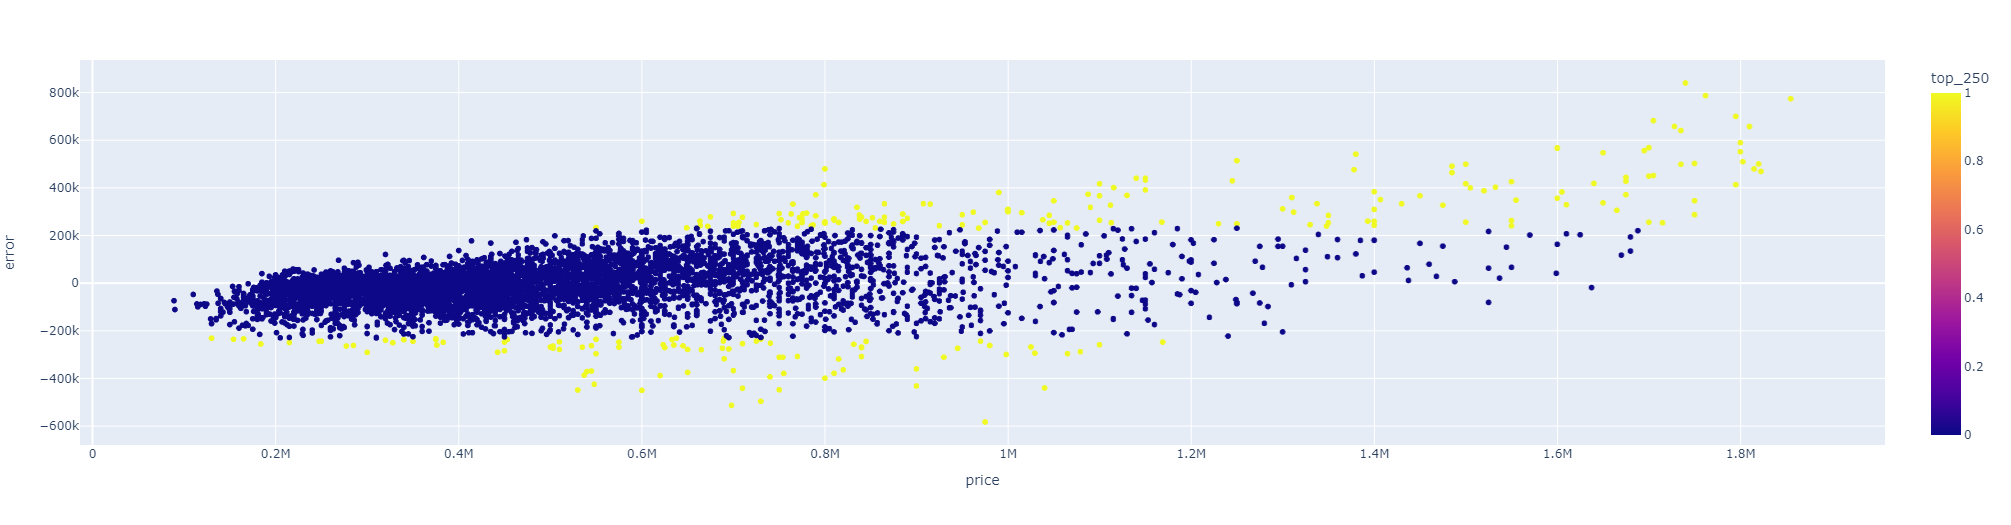

In [ ]:
fig = px.scatter(df_error_xgbr, x='sqft_above', y='error', color='price', hover_data=['price', 'prediction', 'sqft_above', 'grade', 'sqft_lot', 'bathrooms', 'bedrooms', 'top_250'])
fig.show()

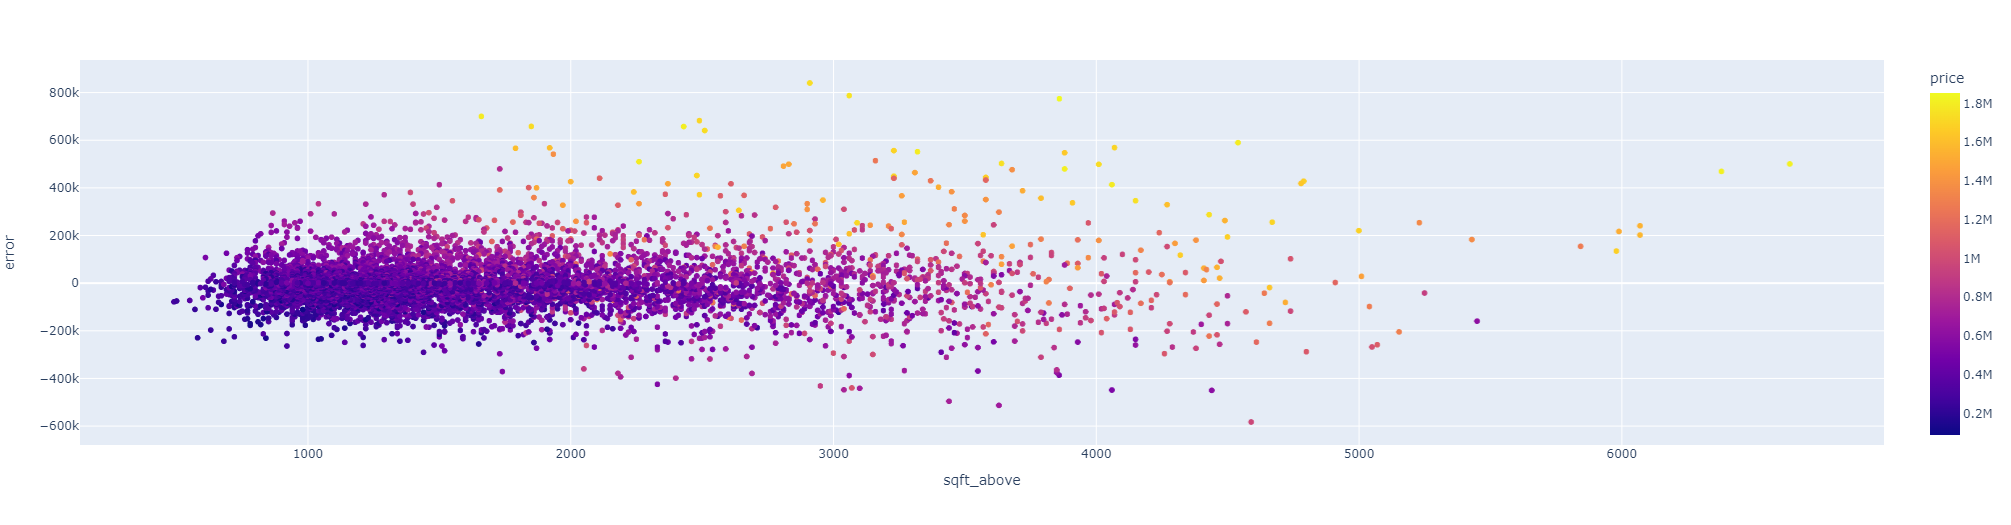

Both models aren't capable of predicting accurately for rows with high prices so I'm going to delete these rows to make future models not try to learn to predict for them and get worse results predicting for rest of the data.

In [ ]:
df_clusters = df_clusters[df_clusters['price'] < 1.45e6]
df_coords = df_coords[df_coords['price'] < 1.45e6]
X_clu = df_clusters.drop('price', axis='columns')
X_co = df_coords.drop('price', axis='columns')
y = df_coords['price']

In [ ]:
X_clu.to_csv('/content/drive/MyDrive/regression project/X_clu.csv', index=False)
y.to_csv('/content/drive/MyDrive/regression project/y_clu.csv', index=False)
X_co.to_csv('/content/drive/MyDrive/regression project/X_co.csv', index=False)

#Linear regression

Now I'm going to train different models using gridsearchcv for hyperparameter search starting with linear regression.

One hot encoding and scaling will be done on the fly for each grid search fold by columntransformer.

My strategy for hyperparameter search is to start with few candidate values, but with wide range, then do another grid search with range of candiate values narrowed down and centered at value selected by previous grid search and repeat this process until there will be no score improvement.

In [ ]:
lr_pipeline = Pipeline([
                        ('one_hot_and_scale', one_hot_and_scale),
                        ('linear_regression', lr)
])

In [ ]:
parameters = {
    'linear_regression__fit_intercept':[True, False]
}

In [ ]:
lr_grid = GridSearchCV(lr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
lr_grid.fit(X_clu, y)

In [ ]:
lr_grid.best_score_ * -1

98571.7560743937

In [ ]:
def get_results(model):
  results_common_cols = ['mean_fit_time', 'std_fit_time','mean_score_time', 'std_score_time', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score']
  results = pd.DataFrame(model.cv_results_)
  results = pd.DataFrame(results.loc[model.best_index_])
  results.columns = [model.estimator.steps[-1][0]]
  results = results.loc[results_common_cols]
  for idx in ['split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score']:
    results.loc[idx] = results.loc[idx] * -1

  return np.round(results, 2)

In [ ]:
results = get_results(lr_grid)
results

,linear_regression
mean_fit_time,0.055013
std_fit_time,0.007771
mean_score_time,0.017139
std_score_time,0.001384
params,{'linear_regression__fit_intercept': True}
split0_test_score,99575.369747
split1_test_score,98816.559566
split2_test_score,99449.989166
split3_test_score,96789.173382
split4_test_score,98227.688512


#ElasticNet

Now let's see if L1 or L2 regularizations will bring performance improvement.

In [ ]:
elastic = ElasticNet()

In [ ]:
elastic_pipeline = Pipeline([
                        ('one_hot_and_scale', one_hot_and_scale),
                        ('elastic', elastic)
])

In [ ]:
parameters = {
    'elastic__fit_intercept':[True, False],
    'elastic__alpha':[0.01, 0.1, 0.5, 0.75, 1, 2, 3, 10, 100],
    'elastic__l1_ratio':[0, 0.2, 0.4, 0.6, 0.8, 1]
}

In [ ]:
elastic_grid = GridSearchCV(elastic_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
elastic_grid.fit(X_clu, y)

In [ ]:
elastic_grid.best_params_

{'elastic__alpha': 0.5, 'elastic__fit_intercept': True, 'elastic__l1_ratio': 1}

In [ ]:
elastic_grid.best_score_ *-1

98571.6965253026

In [ ]:
def get_and_concat_results(results, model):
  temp_results = get_results(model)
  results = pd.concat([results, temp_results], axis=1)
  return results

After grid search alpha is set to 0.5 but RMSE is identical which means that some reguralization is beneficial. Regularizing linear regression will make it less sensivitive to variation in unseen data and hopefully it will generalize better.

In [ ]:
results = get_and_concat_results(results, elastic_grid)
results

,linear_regression,elastic
mean_fit_time,0.055013,0.077879
std_fit_time,0.007771,0.002473
mean_score_time,0.017139,0.010774
std_score_time,0.001384,0.001534
params,{'linear_regression__fit_intercept': True},"{'elastic__alpha': 0.5, 'elastic__fit_intercep..."
split0_test_score,99575.369747,99563.467904
split1_test_score,98816.559566,98819.453898
split2_test_score,99449.989166,99451.161911
split3_test_score,96789.173382,96788.539629
split4_test_score,98227.688512,98235.859285


#Support Vector Regressor

Next step is training SupportVectorRegressor.

In [ ]:
SVRegressor = SVR()

In [ ]:
svr_pipeline = Pipeline([
                        ('scaler', StandardScaler()),
                        ('SVR', SVRegressor)
])

In [ ]:
parameters = {
    'SVR__C':[0.1, 0.5, 1, 5, 10, 100],
    'SVR__kernel':['rbf', 'poly', 'sigmoid'],
    'SVR__degree':[1, 2, 3],
    'SVR__gamma':['auto', 'scale'],
    'SVR__epsilon': [5e4, 1e5, 1.5e5, 2e5]
}

In [ ]:
svr_grid = GridSearchCV(svr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [ ]:
svr_grid.fit(X_co, y)

In [ ]:
svr_grid.best_score_ *-1 

191398.5757453176

In [ ]:
svr_grid.best_params_

{'SVR__C': 100,
 'SVR__degree': 1,
 'SVR__epsilon': 50000.0,
 'SVR__gamma': 'auto',
 'SVR__kernel': 'rbf'}

After first grid search C and epsilon are set to they boundary values and RMSE is high. I'm going to extend ranges for C and epsilon because they clearly were too narrow as SVR had much worse score compared to LR.

In [ ]:
parameters = {
    'SVR__C':[100, 1e4, 1e5, 3e5],
    'SVR__kernel':['rbf', 'poly', 'sigmoid'],
    'SVR__gamma':['auto', 'scale'],
    'SVR__degree':[1, 2, 3],
    'SVR__epsilon': [1e4, 2.5e4, 5e4, 7.5e4]
}

In [ ]:
svr_grid = GridSearchCV(svr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [ ]:
svr_grid.fit(X_co, y)

Another grid search brought improvement to RMSE lowering it by 100k. C is set to 300k and epsilon to 25k. In next grid search I'm going to try values even grater than 300k for C and zoom in on values around 25k for epsilon.

In [ ]:
svr_grid.best_score_ *-1

90430.53067558246

In [ ]:
svr_grid.best_params_

{'SVR__C': 300000.0,
 'SVR__degree': 1,
 'SVR__epsilon': 25000.0,
 'SVR__gamma': 'scale',
 'SVR__kernel': 'rbf'}

In [ ]:
parameters = {
    'SVR__C':[2e5, 3e5, 5e5, 6e5],
    'SVR__kernel':['rbf'],
    'SVR__gamma':['auto', 'scale'],
    'SVR__epsilon': [1.5e4, 2.5e4, 4e4]
}

In [ ]:
svr_grid = GridSearchCV(svr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [ ]:
svr_grid.fit(X_co, y)

Another grid search also improved RMSE but this time only by less than 1k. I'm satisfied with this score and I'm not going to do another grid search.

In [ ]:
svr_grid.best_score_ *-1

89628.6028862101

In [ ]:
svr_grid.best_params_

{'SVR__C': 600000.0,
 'SVR__epsilon': 40000.0,
 'SVR__gamma': 'auto',
 'SVR__kernel': 'rbf'}

I'm refitting gridsearch object with 5 cv folds because my function for collecting results requires that.

In [ ]:
parameters = {
    'SVR__C':[6e5],
    'SVR__kernel':['rbf'],
    'SVR__gamma':['auto'],
    'SVR__epsilon': [4e4]
}

In [ ]:
svr_grid = GridSearchCV(svr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

I'm fitting gridsearch object again but this time using 5 cv splits instead of 3 to have a fair comparison with other models. Using more splits resulted in RMSE improvment of almost 1k.

In [ ]:
svr_grid.fit(X_co, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END SVR__C=600000.0, SVR__epsilon=40000.0, SVR__gamma=auto, SVR__kernel=rbf; total time=   7.3s
[CV] END SVR__C=600000.0, SVR__epsilon=40000.0, SVR__gamma=auto, SVR__kernel=rbf; total time=   7.1s
[CV] END SVR__C=600000.0, SVR__epsilon=40000.0, SVR__gamma=auto, SVR__kernel=rbf; total time=   7.2s
[CV] END SVR__C=600000.0, SVR__epsilon=40000.0, SVR__gamma=auto, SVR__kernel=rbf; total time=   6.6s
[CV] END SVR__C=600000.0, SVR__epsilon=40000.0, SVR__gamma=auto, SVR__kernel=rbf; total time=   7.9s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVR', SVR())]),
             param_grid={'SVR__C': [600000.0], 'SVR__epsilon': [40000.0],
                         'SVR__gamma': ['auto'], 'SVR__kernel': ['rbf']},
             scoring='neg_root_mean_squared_error', verbose=2)

In [ ]:
svr_grid.best_score_ *-1

88672.83320799335

In [ ]:
results = get_and_concat_results(results, svr_grid)
results

,linear_regression,elastic,SVR
mean_fit_time,0.055013,0.077879,7.192575
std_fit_time,0.007771,0.002473,0.401342
mean_score_time,0.017139,0.010774,0.029474
std_score_time,0.001384,0.001534,0.004665
params,{'linear_regression__fit_intercept': True},"{'elastic__alpha': 0.5, 'elastic__fit_intercep...","{'SVR__C': 600000.0, 'SVR__epsilon': 40000.0, ..."
split0_test_score,99575.369747,99563.467904,91072.624343
split1_test_score,98816.559566,98819.453898,88040.618893
split2_test_score,99449.989166,99451.161911,90467.657792
split3_test_score,96789.173382,96788.539629,87398.261531
split4_test_score,98227.688512,98235.859285,86385.003481


#K Neighbors Regressor

Now I'll perform grid search for KNeighborsRegressor parameters.

I will try 4 different variants for KNR:

1. Using cluster column with coordinates dropped and ordinal variables one hot encoded

2. Using cluster column but ordinal variables aren't one hot encoded

3. Using coordinates with ordinal variables one hot encoded

4. Using coordinates but ordinal variables aren't one hot encoded

In [ ]:
knr = KNeighborsRegressor()

In [ ]:
one_hot_and_scale = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), [4, 5, 12]),
    ('scaler', StandardScaler(), [0, 1, 2, 3, 6, 7, 8, 9, 10, 11])
], remainder='passthrough')

In [ ]:
X_clu.head()

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,sqft_living15,sqft_lot15,yr_since_renovation,cluster
0,3,1.0,5650,1.0,0,7,1180,0,1955,1340,5650,59.0,8
1,3,2.0,7242,2.0,0,7,2170,400,1951,1690,7639,23.0,19
2,2,1.0,10000,1.0,0,6,770,0,1933,2720,8062,82.0,3
3,4,3.0,5000,1.0,0,7,1050,910,1965,1360,5000,49.0,0
4,3,2.0,8080,1.0,0,8,1680,0,1987,1800,7503,28.0,4


In [ ]:
knr_pipeline_one_hot_cluster = Pipeline([
                        ('one_hot_and_scale', one_hot_and_scale),
                        ('knr_onehot_cluster', knr)                          
])

In [ ]:
parameters = {
    'knr_onehot_cluster__n_neighbors':[3, 5, 8, 10, 15, 20, 25, 30, 50, 100],
    'knr_onehot_cluster__weights':['uniform', 'distance'],
    'knr_onehot_cluster__metric':['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
knr_grid_onehot_cluster = GridSearchCV(knr_pipeline_one_hot_cluster, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
knr_grid_onehot_cluster.fit(X_clu, y)

In [ ]:
knr_grid_onehot_cluster.best_score_ *-1

101255.51906750842

In [ ]:
knr_grid_onehot_cluster.best_params_

{'knr_onehot_cluster__metric': 'manhattan',
 'knr_onehot_cluster__n_neighbors': 8,
 'knr_onehot_cluster__weights': 'uniform'}

In [ ]:
one_hot_cluster_scale = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), [12]),
    ('scaler', StandardScaler(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
], remainder='passthrough')

In [ ]:
knr_pipeline_cluster = Pipeline([
                        ('one_hot_only_cluster_scale', one_hot_cluster_scale),
                        ('knr_cluster', knr)                          
])

In [ ]:
parameters = {
    'knr_cluster__n_neighbors':[3, 5, 8, 10, 15, 20, 25, 30, 50, 100],
    'knr_cluster__weights':['uniform', 'distance'],
    'knr_cluster__metric':['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
knr_grid_cluster = GridSearchCV(knr_pipeline_cluster, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
knr_grid_cluster.fit(X_clu, y)

In [ ]:
knr_grid_cluster.best_score_ *-1

99811.54004204192

In [ ]:
knr_grid_cluster.best_params_

{'knr_cluster__metric': 'manhattan',
 'knr_cluster__n_neighbors': 10,
 'knr_cluster__weights': 'uniform'}

In [ ]:
X_co.head()

,bedrooms,bathrooms,sqft_lot,floors,view,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,yr_since_renovation
0,3,1.0,5650,1.0,0,7,1180,0,1955,47.5112,-122.257,1340,5650,59.0
1,3,2.0,7242,2.0,0,7,2170,400,1951,47.7210,-122.319,1690,7639,23.0
2,2,1.0,10000,1.0,0,6,770,0,1933,47.7379,-122.233,2720,8062,82.0
3,4,3.0,5000,1.0,0,7,1050,910,1965,47.5208,-122.393,1360,5000,49.0
4,3,2.0,8080,1.0,0,8,1680,0,1987,47.6168,-122.045,1800,7503,28.0


In [ ]:
one_hot_scale_coords = ColumnTransformer([
    ('one_hot', OneHotEncoder(sparse=False), [4, 5]),
    ('scaler', StandardScaler(), [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13])
], remainder='passthrough')

In [ ]:
knr_pipeline_coords_onehot = Pipeline([
                        ('one_hot_only_cluster_scale', one_hot_scale_coords),
                        ('knr_coords_onehot', knr)                          
])

In [ ]:
parameters = {
    'knr_coords_onehot__n_neighbors':[3, 5, 8, 10, 15, 20, 25, 30, 50, 100],
    'knr_coords_onehot__weights':['uniform', 'distance'],
    'knr_coords_onehot__metric':['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
knr_grid_coords_onehot = GridSearchCV(knr_pipeline_coords_onehot, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
knr_grid_coords_onehot.fit(X_co, y)

In [ ]:
knr_grid_coords_onehot.best_score_ *-1

94829.91492701904

In [ ]:
knr_grid_coords_onehot.best_params_

{'knr_coords_onehot__metric': 'manhattan',
 'knr_coords_onehot__n_neighbors': 8,
 'knr_coords_onehot__weights': 'uniform'}

In [ ]:
knr_pipeline_coords = Pipeline([
                        ('scaler', StandardScaler()),
                        ('knr_coords', knr)                          
])

In [ ]:
parameters = {
    'knr_coords__n_neighbors':[3, 5, 8, 10, 15, 20, 25, 30, 50, 100],
    'knr_coords__weights':['uniform', 'distance'],
    'knr_coords__metric':['euclidean', 'manhattan', 'minkowski']
}

In [ ]:
knr_grid_coords = GridSearchCV(knr_pipeline_coords, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
knr_grid_coords.fit(X_co, y)

In [ ]:
knr_grid_coords.best_score_ *-1

95147.98772475371

In [ ]:
knr_grid_coords.best_params_

{'knr_coords__metric': 'manhattan',
 'knr_coords__n_neighbors': 8,
 'knr_coords__weights': 'uniform'}

Variant number 3 achieved the best results. Variants 3 and 4 had RMSE lower by 5k comparing to variants 1 and 2 meaning that it's better to use raw coordinates instead of clusters for KNR. Difference between one hot encoding and not doing that for ordinal features is about 300 in both cases but for variants 1 and 2 it's better not to encode, for variants 3 and 4 it's the opposite.

In [ ]:
results = get_and_concat_results(results, knr_grid_coords_onehot)
results

,linear_regression,elastic,SVR,knr_coords_onehot
mean_fit_time,0.05501337051391601,0.07787919044494629,7.192574548721313,0.020387
std_fit_time,0.0077708600383914845,0.002472961770433974,0.4013424666626783,0.004226
mean_score_time,0.017138576507568358,0.010774326324462891,0.02947392463684082,1.573666
std_score_time,0.0013844407769762963,0.0015336070263217796,0.004665054767365556,0.1828
params,{'linear_regression__fit_intercept': True},"{'elastic__alpha': 0.5, 'elastic__fit_intercep...","{'SVR__C': 600000.0, 'SVR__epsilon': 40000.0, ...","{'knr_coords_onehot__metric': 'manhattan', 'kn..."
split0_test_score,99575.36974693724,99563.46790373612,91072.62434328058,96725.866075
split1_test_score,98816.55956558876,98819.45389791045,88040.6188931588,93833.151233
split2_test_score,99449.98916561116,99451.16191052445,90467.65779153175,96129.220305
split3_test_score,96789.17338206647,96788.53962909615,87398.26153131889,92677.666992
split4_test_score,98227.68851176486,98235.85928524575,86385.00348067675,94783.67003


#XGBoost Regressor

Last type of model I'm going to use is XGBoost Regressor.

In [ ]:
xgbr = XGBRegressor()

In [ ]:
parameters = {
    'eta':[0.1, 0.2, 0.3],
    'gamma':[0, 10, 100],
    'min_child_weight':[1, 10, 100],
    'max_depth':[10, 15],
    'lambda':[1, 3],
    'alpha':[0, 1],
    'tree_method':['gpu_hist'],
    'max_bin':[512],
}

In [ ]:
xgbr_grid = GridSearchCV_sk(xgbr, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=3, verbose=2)

In [ ]:
xgbr_grid.fit(X_co, y)

76K RMSE is by far the best score I got. I'm going to do another grid search in hopes of further improvement.

In [ ]:
xgbr_grid.best_score_*-1

76059.6579601832

In [ ]:
xgbr_grid.best_params_

{'alpha': 1,
 'eta': 0.1,
 'gamma': 0,
 'lambda': 3,
 'max_bin': 512,
 'max_depth': 15,
 'min_child_weight': 100,
 'tree_method': 'gpu_hist'}

In [ ]:
parameters = {
    'eta':[0.01, 0.05, 0.1, 0.15],
    'gamma':[0],
    'min_child_weight':[50, 100, 150, 300],
    'max_depth':[15],
    'lambda':[3],
    'tree_method':['gpu_hist'],
    'max_bin':[512],
    'colsample_bylevel':[0.5, 0.8, 1],
    'colsample_bytree':[0.5, 0.8, 1],

}

In [ ]:
xgbr_grid = GridSearchCV(xgbr, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
xgbr_grid.fit(X_co, y)

After second round of grid search RMSE is 74K.

In [ ]:
xgbr_grid.best_score_*-1

73999.4996112401

In [ ]:
xgbr_grid.best_params_

{'colsample_bylevel': 1,
 'colsample_bytree': 0.8,
 'eta': 0.1,
 'gamma': 0,
 'lambda': 3,
 'max_bin': 512,
 'max_depth': 15,
 'min_child_weight': 50,
 'tree_method': 'gpu_hist'}

I'm creating pipeline with only one step because my evaluation function requires that.

In [ ]:
xgbr_pipeline = Pipeline([
                        ('xgbr', xgbr)                          
])

In [ ]:
parameters = {
    'xgbr__eta':[0.1],
    'xgbr__gamma':[0],
    'xgbr__min_child_weight':[50],
    'xgbr__max_depth':[15],
    'xgbr__lambda':[3],
    'xgbr__tree_method':['gpu_hist'],
    'xgbr__max_bin':[512],
    'xgbr__colsample_bylevel':[1],
    'xgbr__colsample_bytree':[0.8],

}

In [ ]:
xgbr_grid = GridSearchCV(xgbr_pipeline, param_grid=parameters, scoring='neg_root_mean_squared_error', cv=5, verbose=2)

In [ ]:
xgbr_grid.fit(X_co, y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END xgbr__colsample_bylevel=1, xgbr__colsample_bytree=0.8, xgbr__eta=0.1, xgbr__gamma=0, xgbr__lambda=3, xgbr__max_bin=512, xgbr__max_depth=15, xgbr__min_child_weight=50, xgbr__tree_method=gpu_hist; total time=   1.8s
[CV] END xgbr__colsample_bylevel=1, xgbr__colsample_bytree=0.8, xgbr__eta=0.1, xgbr__gamma=0, xgbr__lambda=3, xgbr__max_bin=512, xgbr__max_depth=15, xgbr__min_child_weight=50, xgbr__tree_method=gpu_hist; total time=   1.3s
[CV] END xgbr__colsample_bylevel=1, xgbr__colsample_bytree=0.8, xgbr__eta=0.1, xgbr__gamma=0, xgbr__lambda=3, xgbr__max_bin=512, xgbr__max_depth=15, xgbr__min_child_weight=50, xgbr__tree_method=gpu_hist; total time=   1.2s
[CV] END xgbr__colsample_bylevel=1, xgbr__colsample_bytree=0.8, xgbr__eta=0.1, xgbr__gamma=0, xgbr__lambda=3, xgbr__max_bin=512, xgbr__max_depth=15, xgbr__min_child_weight=50, xgbr__tree_method=gpu_hist; total time=   1.2s
[CV] END xgbr__colsample_bylevel=1, xgbr__colsamp

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgbr',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     enable_categorical=False,
                                                     gamma=None, gpu_id=None,
                                                     importance_type=None,
                                                     interaction_constraints=None,
                                                     learning_rate=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                    

In [ ]:
results = get_and_concat_results(results, xgbr_grid)

#Final results

XGradient Boost produced the best results beating second best SVR by 14k on RMSE. Standard deviation of scores for 5 cv folds is only 2k and it's performance is similar for all folds.

In [ ]:
results

,linear_regression,elastic,SVR,knr_coords_onehot,xgbr
mean_fit_time,0.05501337051391601,0.07787919044494629,7.192574548721313,0.020387,1.316107702255249
std_fit_time,0.0077708600383914845,0.002472961770433974,0.4013424666626783,0.004226,0.2177857857426855
mean_score_time,0.017138576507568358,0.010774326324462891,0.02947392463684082,1.573666,0.028029251098632812
std_score_time,0.0013844407769762963,0.0015336070263217796,0.004665054767365556,0.1828,0.01533251972076087
params,{'linear_regression__fit_intercept': True},"{'elastic__alpha': 0.5, 'elastic__fit_intercep...","{'SVR__C': 600000.0, 'SVR__epsilon': 40000.0, ...","{'knr_coords_onehot__metric': 'manhattan', 'kn...","{'xgbr__colsample_bylevel': 1, 'xgbr__colsampl..."
split0_test_score,99575.36974693724,99563.46790373612,91072.62434328058,96725.866075,75653.40194034323
split1_test_score,98816.55956558876,98819.45389791045,88040.6188931588,93833.151233,73127.90725021456
split2_test_score,99449.98916561116,99451.16191052445,90467.65779153175,96129.220305,76873.01976571727
split3_test_score,96789.17338206647,96788.53962909615,87398.26153131889,92677.666992,73081.9756479832
split4_test_score,98227.68851176486,98235.85928524575,86385.00348067675,94783.67003,71261.19345194224


In [ ]:
results.to_csv('/content/drive/MyDrive/regression project/results_df.csv', index=True)